# Data preparation

## Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os. chdir('/content/gdrive/MyDrive/full data_polished_2')
#!ls

In [ ]:
# Parameters
max_nr_samples = 1242
nr_samples_to_be_processed = 1242
year_of_experiment = 2020
min_size_fixations = 60 # Minimum number of fixation size, ms
nr_females = 614
nr_males =  549
max_time_step_size = 50
#velocity_cap = 25

In [ ]:
import pickle
import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
from scipy import stats
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns; sns.set_theme(color_codes=True)

os.chdir('/content/gdrive/MyDrive/full data_polished_2')
filename='full_data_60'
infile = open(filename,'rb')
full_data = pickle.load(infile)
infile.close

filename='I2MC_data_60'
infile = open(filename,'rb')
I2MC_data = pickle.load(infile)
infile.close

os. chdir('/content/gdrive/MyDrive')

filename='full_data_chris'
infile = open(filename,'rb')
full_data_chris = pickle.load(infile)
infile.close



<function BufferedReader.close>

## Otsu

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import glob, os
import numpy as np
import math
from skimage import data
from skimage.filters import threshold_otsu
import cv2
import os.path
from os import path
import statsmodels.api as sm
from scipy import stats
import pickle

subprocess.run('clear')

# *************************************
# *************************************
# Functions
def data_cleaning_polishing():
    counter = 0
    for file in glob.glob("*.txt"):
        counter +=1
        print('Processing file: ',counter, end='\r')
        #os.rename(file, str(counter)+'.txt')

        with open(file,'r+') as f1:
            data = f1.read()
            data_polished = data.replace('(',' ')
            data_polished = data_polished.replace(')',' ')
            f1.seek(0)
            f1.write(data_polished)
            f1.truncate()

        f1 = open(file, "r")
        lines = f1.readlines()
        f1.close()

        f2 = open ('metadata_'+str(counter),'w')
        for k in range (6):
            f2.write (lines [k])
        f2.close()

        f3 = open ('data_'+str(counter),'w')
        del lines [0:6]
        for line in lines:
            f3.write(line)
        f3.close()

def time_correction(time_inp):
  problem_location=np.where(np.diff(time_inp)>35)
  correction = np.diff(time_inp)[problem_location][0]
  time_inp [problem_location[0][0]+1:]=time_inp [problem_location[0][0]+1:]-correction+17
  return time_inp

def read_data(subject_number):
    data_frame = pd.read_csv('data_'+str(subject_number), header = None)
    x = data_frame[0].to_numpy()
    y = data_frame [1].to_numpy()
    time =data_frame[2].to_numpy()
    if np.max(np.diff(time)) > max_time_step_size:
        new_time = time_correction(time)
        time = new_time
    return x,y,time

def read_metadata(subject_number):
    f = open ('metadata_'+str(subject_number),'r')
    lines = f.readlines()
    f.close()
    lines_without_endofline = []
    for k in range (len(lines)):
        line_without_endofline = lines[k].replace('\n','')
        lines_without_endofline.append(line_without_endofline)
    return lines_without_endofline

def calculate_velocity(subject_number):
    x,y,time = read_data(subject_number)
    length = []
    duration = []
    for k in range(len(time)):
        if k > 0:
            #print (k)
            length.append( math.sqrt( (x[k]-x[k-1])**2 +(y[k]-y[k-1])**2 ) )
            duration.append ( time [k]-time[k-1] )
    velocity = np.array(length) /np.array(duration)
    return velocity

def global_thresholding(velocity):
    # More information: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html
    # Theoretical background: https://en.wikipedia.org/wiki/Otsu%27s_method
    velocity_cap = np.mean(velocity)+np.std(velocity)
    #print (np.mean(velocity))
    #print(np.std(velocity))
    velocity = np.clip(velocity, 0, velocity_cap)
    thresh = threshold_otsu(velocity)
    thresh = thresh #+ np.median (velocity)
    binary = velocity > thresh
    return thresh, binary

def find_blocks(binary):
    # More information: https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/
    # More information: https://stackoverflow.com/questions/51523765/how-to-use-opencv-connectedcomponents-to-get-the-images
    binary_uint8 = (binary * 255).astype(np.uint8)
    num_blocks, labels_blocks = cv2.connectedComponents(binary_uint8,connectivity=4)
    return num_blocks, labels_blocks

def find_fixations_saccades(binary,time,min_size_fixations):
    invert_binary=(~binary.astype(bool)).astype(int)
    num_fixations, labels_fixations = find_blocks (invert_binary)

    length_fixation = np.zeros(num_fixations)
    #print (time)

    for k in range (num_fixations):
        length_fixation [k] = np.count_nonzero( labels_fixations == k)
        position_data = np.where(labels_fixations == k)
        #print (shape(position_data))
        start_position = int(position_data [0][0])
        #print (start_position)
        fixation_time = time [start_position+int(length_fixation[k])]-time [int(start_position)]
        #print (fixation_time)
        if fixation_time < min_size_fixations:
            locations_of_this_too_small_fixation = np.where( labels_fixations == k)
            for l in range (len(locations_of_this_too_small_fixation[0])):
                binary [locations_of_this_too_small_fixation [0][l]] = True

    invert_binary=(~binary.astype(bool)).astype(int)
    num_fixations, labels_fixations = find_blocks (invert_binary)
    num_saccades, labels_saccades = find_blocks (binary)
    length_saccades = np.zeros(num_saccades)
    start_positions_fixations = np.zeros(num_fixations)
    start_positions_saccades = np.zeros(num_saccades)

    length_fixation = np.zeros(num_fixations)
    for k in range (num_fixations):
        length_fixation [k] = np.count_nonzero( labels_fixations == k)

    for k in range (num_fixations):
            length_fixation [k] = np.count_nonzero( labels_fixations == k)
            fixation_positions = np.where(labels_fixations == k)
            start_positions_fixations [k] = fixation_positions [0][0]

    for k in range (num_saccades):
        length_saccades [k] = np.count_nonzero( labels_saccades == k)
        saccade_positions = np.where(labels_saccades == k)
        start_positions_saccades [k] = saccade_positions [0][0]

    return binary, start_positions_fixations[1:], length_fixation [1:], start_positions_saccades[1:], length_saccades[1:]

def prepare_full_data(nr_samples_to_be_processed):
    if path.exists("data_1"):
        print ('Data files are already generated.')
    else:
        data_cleaning_polishing()

    full_data = []
    for k in range (1,nr_samples_to_be_processed+1):
        print('Preparing data, subject nr: ',k, end='\r')
        x,y,time_ = read_data(k)
        velocity = calculate_velocity(k)
        meta_data = read_metadata(k)
        thresh, binary_preliminary = global_thresholding(velocity)
        binary, start_positions_fixations, length_fixation, start_positions_saccades, length_saccades = find_fixations_saccades(binary_preliminary,time_, min_size_fixations)
        full_data.append ([x,y,time_,velocity,thresh,binary,start_positions_fixations,length_fixation, start_positions_saccades, length_saccades,meta_data])
        #print (start_positions_fixations)
        #print (length_fixation)
        #print('\n')
        #plt.plot(velocity)
        #plt.plot(binary)
        #plt.show()
        #plt.plot(x,y)
        #plt.show()
    #print(full_data[0][10][2])
    print('\n')
    return full_data

# *************************************
# *************************************
# Main program
# *************************************
# *************************************

######################################
# Prepare data
full_data = prepare_full_data(nr_samples_to_be_processed)
filename = 'full_data_60'
outfile = open(filename,'wb')
pickle.dump(full_data,outfile)
outfile.close()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data files are already generated.




## I2MC

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 19 10:54:00 2019
@author: Jonathan
"""

# =============================================================================
# Import libraries
# =============================================================================
import numpy as np
import scipy
import scipy.interpolate as interp
import scipy.signal
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import copy

# =============================================================================
# # ToDo 
# =============================================================================
# General stuff 
#- Check all the functions help text (type, description etc)

# Functions (Interpolate)
# - Can we use my implementation? not steffen

# Functions (CLUSTERING)
#- twoClusterWeighting
#   - Downsampling
#   - missing values handeling?
#   - Edges and going back for the latest samples

# Questions
# When getting median gaze position (fixation), the inetrpolated values are ignored. 
#   Is this intended, then whats the point of interpolaiton, besides the clustering?
# Not all results are identical to matlab version
#   for instance, trial 1 pp2, fix5 and 6 have a slight overlap
#   pp2 trial 3,4 and 5 has a fixations thats to short compared to matlab (almost last fixation)


# =============================================================================
# Helper functions
# =============================================================================
def isNumber(s):
    try:
        np.array(s,dtype=float)
        return True
    except ValueError:
        return False    

def checkNumeric(k,v):
    assert isNumber(v), 'The value of "{}" is invalid. Expected input to be one of these types:\n\ndouble, single, uint8, uint16, uint32, uint64, int8, int16, int32, int64\n\nInstead its type was {}.'.format(k, type(v))

def checkScalar(k,v):
    assert np.ndim(v) == 0, 'The value of "{}" is invalid. Expected input to be a scalar.'.format(k)

def checkNumel2(k,v):
    assert np.shape(v) == (2,), 'The value of "{}" is invalid. Expected input to be an array with number of elements equal to 2.'.format(k)

def checkInt(k,v):
    assert np.sum(np.array(v)%1) == 0, 'The value of "{}" is invalid. Expected input to be integer-valued.'.format(k)
    
def checkFun(k, d, s):
    assert k in d.keys(), 'I2MCfunc: "{}" must be specified using the "{}" option'.format(s, k)
    assert isNumber(d[k]), 'I2MCfunc: "{}" must be set as a number using the "{}" option'.format(s, k) 

def angleToPixels(angle, screenDist, screenW, screenXY):
    """
    Calculate the number of pixels which equals a specified angle in visual
    degrees, given parameters. Calculates the pixels based on the width of
    the screen. If the pixels are not square, a separate conversion needs
    to be done with the height of the screen.\n
    "angleToPixelsWH" returns pixels for width and height.
    Parameters
    ----------
    angle : float or int
        The angle to convert in visual degrees
    screenDist : float or int
        Viewing distance in cm
    screenW : float or int
        The width of the screen in cm
    screenXY : tuple, ints
        The resolution of the screen (width - x, height - y), pixels
    Returns
    -------
    pix : float
        The number of pixels which corresponds to the visual degree in angle,
        horizontally
    Examples
    --------
    >>> pix = angleToPixels(1, 75, 47.5, (1920,1080))
    >>> pix
    52.912377341863817
    """
    pixSize = screenW / float(screenXY[0])
    angle = np.radians(angle / 2.0)
    cmOnScreen = np.tan(angle) * float(screenDist)
    pix = (cmOnScreen / pixSize) * 2

    return pix

def getMissing(L_X, R_X, missingx, L_Y, R_Y, missingy):
    """
    Gets missing data and returns missing data for left, right and average
    
    Parameters
    ----------
    L_X : np.array
        Left eye X gaze position data
    R_X : np.array
        Right eye X gaze position data
    missingx : Not defined
        The values reflecting mising values for X coordinates in the dataset
    L_Y : np.array
        Left eye Y gaze position data
    R_Y : np.array
        Right eye Y gaze position data
    missingy : Not defined
        The value reflectings mising values for Y coordinates in the dataset
    Returns
    -------
    qLMiss : np.array - Boolean
        Boolean with missing values for the left eye
    qRMiss : np.array - Boolean
        Boolean with missing values for the right eye
    qBMiss : np.array - Boolean
        Boolean with missing values for both eyes
        
    Examples
    --------
    >>>
    """

    # Get where the missing is
    
    # Left eye
    qLMissX = np.logical_or(L_X == missingx, np.isnan(L_X))
    qLMissY = np.logical_or(L_Y == missingy, np.isnan(L_Y))
    qLMiss = np.logical_and(qLMissX, qLMissY)
    
    # Right
    qRMissX = np.logical_or(R_X == missingx, np.isnan(R_X))
    qRMissY = np.logical_or(R_Y == missingy, np.isnan(R_Y))
    qRMiss = np.logical_and(qRMissX, qRMissY)

    # Both eyes
    qBMiss = np.logical_and(qLMiss, qRMiss)

    return qLMiss, qRMiss, qBMiss


def averageEyes(L_X, R_X, missingx, L_Y, R_Y, missingy):
    """
    Averages data from two eyes. Take one eye if only one was found.
    
    Parameters
    ----------
    L_X : np.array
        Left eye X gaze position data
    R_X : np.array
        Right eye X gaze position data
    missingx : Not defined
        The values reflecting mising values for X coordinates in the dataset
    L_Y : np.array
        Left eye Y gaze position data
    R_Y : np.array
        Right eye Y gaze position data
    missingy : Not defined
        The values reflecting mising values for Y coordinates in the dataset
    Returns
    -------
    xpos : np.array
        The average Y gaze position
    ypos : np.array
        The average X gaze position
    qBMiss : np.array - Boolean
        Boolean with missing values for both eyes
    qLMiss : np.array - Boolean
        Boolean with missing values for the left eye
    qRMiss : np.array - Boolean
        Boolean with missing values for the right eye
    Examples
    --------
    >>>
    """

    xpos = np.zeros(len(L_X))
    ypos = np.zeros(len(L_Y))
    
    # get missing
    qLMiss, qRMiss, qBMiss = getMissing(L_X, R_X, missingx, L_Y, R_Y, missingy)

    q = np.logical_and(np.invert(qLMiss), np.invert(qRMiss))
    xpos[q] = (L_X[q] + R_X[q]) / 2.
    ypos[q] = (L_Y[q] + R_Y[q]) / 2.
    
    q =  np.logical_and(qLMiss, np.invert(qRMiss))
    xpos[q] = R_X[q]
    ypos[q] = R_Y[q]
    
    q = np.logical_and(np.invert(qLMiss), qRMiss)
    xpos[q] = L_X[q]
    ypos[q] = L_Y[q]
    
    xpos[qBMiss] = np.NAN
    ypos[qBMiss] = np.NAN

    return xpos, ypos, qBMiss, qLMiss, qRMiss

def bool2bounds(b):
    """
    Finds all contiguous sections of true in a boolean
    Parameters
    ----------
    data : np.array
        A 1d np.array containing True, False values.
    
    Returns
    -------
    on : np.array
        The array contains the indexes of the first value = True
    off : np.array
        The array contains the indexes of the last value = True in a sequence
    
    Example
    --------
    >>> import numpy as np
    >>> b = np.array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0])
    >>> on, off = bool2bounds(b)
    >>> print(on)
    [0 4 8]
    >>> print(off)
    [0 6 9]
    """
    b = np.array(np.array(b, dtype = np.bool), dtype=int)
    b = np.pad(b, (1, 1), 'constant', constant_values=(0, 0))
    D = np.diff(b)
    on  = np.array(np.where(D == 1)[0], dtype=int)
    off = np.array(np.where(D == -1)[0] -1, dtype=int)
    return on, off

def getCluster(b):
    '''
    Splits a np.array with True, False values into clusters. A cluster is 
    defined as adjacent points with the same value, e.g. True or False. 
    The output from this function is used to determine cluster sizes when
    running cluster statistics. 
    
    Parameters
    ----------
    b : np.array
        A 1d np.array containing True, False values.
    
    Returns
    -------
    clusters : list of np.arrays
        The list contains the clusters split up. Each cluster in its own
        np.array. 
    indx : list of np.arrays
        The list contains the indexes for each time point in the clusters.     
    
    Example
    --------
    >>> 
    ''' 
    if b.dtype != 'bool':
       b = np.array(b, dtype = np.bool)
    clusters = np.split(b, np.where(np.diff(b) != 0)[0]+1)
    indx = np.split(np.arange(len(b)), np.where(np.diff(b) != 0)[0]+1)
    size = np.array([len(c) for c in indx])
    offC = np.array([np.sum(c) > 0 for c in clusters])
    onC = np.invert(offC)
    offCluster = [indx[i] for i in range(len(offC)) if offC[i]]
    onCluster = [indx[i] for i in range(len(onC)) if onC[i]]
    
    offSize = size[offC]
    onSize = size[onC]
    
    missStart = np.array([c[0] for c in offCluster], dtype=int)
    missEnd = np.array([c[-1] for c in offCluster], dtype=int)
    
    dataStart = np.array([c[0] for c in onCluster], dtype=int)
    dataEnd = np.array([c[-1] for c in onCluster], dtype=int)
    
    return missStart, missEnd, dataStart, dataEnd, onSize, offSize, onCluster, offCluster

def plotResults(data,fix,res=[1920,1080]):
    '''
    Plots the results of the I2MC function
    '''
    
    time = data['time']
    Xdat = np.array([])
    Ydat = np.array([])
    klr  = []
    if 'L_X' in data.keys():
        Xdat = data['L_X']
        Ydat = data['L_Y']
        klr.append('g')
    if 'R_X' in data.keys():
        if len(Xdat) == 0:
            Xdat = data['R_X']
            Ydat = data['R_Y']
        else:
            Xdat = np.vstack([Xdat, data['R_X']])
            Ydat = np.vstack([Ydat, data['R_Y']])
        klr.append('r')
    if 'average_X' in data.keys() and not 'L_X' in data.keys() and not 'R_X' in data.keys():
        if len(Xdat) == 0:
            Xdat = data['average_X']
            Ydat = data['average_Y']
        else:
            Xdat = np.vstack([Xdat, data['average_X']])
            Ydat = np.vstack([Ydat, data['average_Y']])
        klr.append('b')   
    
    # Plot settings
    myfontsize = 10
    myLabelSize = 12
    traceLW = 0.5
    fixLWax1 = res[0]/100
    fixLWax2 = res[1]/100
    
    font = {'size': myfontsize}
    matplotlib.rc('font', **font)
    
    ## plot layout
    f = plt.figure(figsize=(10, 6), dpi=300)
    ax1 = plt.subplot(2,1,1)
    ax1.set_ylabel('Horizontal position (pixels)', size = myLabelSize)
    ax1.set_xlim([0, time[-1]])
    ax1.set_ylim([0, res[0]])

    ### Plot x position
    if len(Xdat.shape) > 1:
        for p in range(Xdat.shape[0]):
            ax1.plot(time,Xdat[p,:],klr[p]+'-', linewidth = traceLW)
    else:
        ax1.plot(time,Xdat,klr[0]+'-', linewidth = traceLW)
    
    ### Plot Y posiiton
    ax2 = plt.subplot(2,1,2,sharex=ax1)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Vertical position (pixels)', size = myLabelSize)
    ax2.set_ylim([0, res[1]])
    if len(Xdat.shape)  > 1:
        for p in range(Ydat.shape[0]):
            ax2.plot(time,Ydat[p,:],klr[p]+'-', linewidth = traceLW)
    else:
        ax2.plot(time,Ydat,klr[0]+'-', linewidth = traceLW)
        
    # add fixations, but adds a shaded area instead of line
    for b in range(len(fix['startT'])):
        ax1.add_patch(patches.Rectangle((fix['startT'][b], fix['xpos'][b] - (fixLWax1/2)),
                                       fix['endT'][b] - fix['startT'][b],
                                       abs(fixLWax1), fill=True, alpha = 0.8, color = 'k',
                                       linewidth = 0, zorder=3))
        ax2.add_patch(patches.Rectangle((fix['startT'][b], fix['ypos'][b] - (fixLWax2/2)),
                                       fix['endT'][b] - fix['startT'][b],
                                       abs(fixLWax2), fill=True, alpha = 0.8, color = 'k',
                                       linewidth = 0, zorder=3))

    return f

# =============================================================================
# Interpolation functions 
# =============================================================================
def findInterpWins(xpos, ypos, missing, windowtime, edgesamples, freq, maxdisp):
    """
    Description
    
    Parameters
    ----------
    xpos : np.array
        X gaze position
    ypos : type
        Y gaze position
    missing : type
        Description
    windowtime : float
        Time of window to interpolate over in ms
    edgesamples : int
        Number of samples at window edge used for interpolating in ms
    freq : float
        Frequency of measurement
    maxdisp : float
        maximum dispersion in position signal (i.e. if signal is in pixels, provide maxdisp in n pixels)
    Returns
    -------
    notAllowed : np.array
        Boolean with True where interpolation is not valid           
        
    Examples
    --------
    >>>
    """          
    # get indices of where missing intervals start and end
    missStart, missEnd = bool2bounds(missing)
    dataStart, dataEnd = bool2bounds(np.invert(missing))
    #missStart, missEnd, dataStart, dataEnd, onSize, offSize, onCluster, offCluster = getCluster(missing)
    
    # Determine windowsamples
    windowsamples = round(windowtime/(1./freq))
    
    # for each candidate, check if have enough valid data at edges to execute
    # interpolation. If not, see if merging with adjacent missing is possible
    # we don't throw out anything we can't deal with yet, we do that below.
    # this is just some preprocessing
    k=0  #was K=1 in matlab
    while k<len(missStart):
        # skip if too long
        if missEnd[k]-missStart[k]+1 > windowsamples:
            k = k+1
            continue

        # skip if not enough data at left edge
        if np.sum(dataEnd == missStart[k]-1) > 0:
            datk = int(np.argwhere(dataEnd==missStart[k]-1))
            if dataEnd[datk]-dataStart[datk]+1 < edgesamples:
                k = k+1
                continue
        
        # if not enough data at right edge, merge with next. Having not enough
        # on right edge of this one, means not having enough at left edge of
        # next. So both will be excluded always if we don't do anything. So we
        # can just merge without further checks. Its ok if it then grows too
        # long, as we'll just end up excluding that too below, which is what
        # would have happened if we didn't do anything here
        datk = np.argwhere(dataStart==missEnd[k]+1)
        if len(datk) > 0:
            datk = int(datk)
            if dataEnd[datk]-dataStart[datk]+1 < edgesamples:
                missEnd = np.delete(missEnd, k)
                missStart = np.delete(missStart, k)
                
                # don't advance k so we check this one again and grow it further if
                # needed
                continue

        # nothing left to do, continue to next
        k = k+1
    
    # mark intervals that are too long to be deleted (only delete later so that
    # below checks can use all missing on and offsets)
    missDur = missEnd-missStart+1
    qRemove = missDur>windowsamples
    
    # for each candidate, check if have enough valid data at edges to execute
    # interpolation and check displacement during missing wasn't too large.
    # Mark for later removal as multiple missing close together may otherwise
    # be wrongly allowed
    for p in range(len(missStart)):
        # check enough valid data at edges
        # missing too close to beginning of data
        # previous missing too close
        # missing too close to end of data
        # next missing too close
        if p != (len(missStart)-1):
            if missStart[p]<edgesamples+1 or \
                    (p>0 and missEnd[p-1] > missStart[p]-edgesamples-1) or \
                    missEnd[p]>len(xpos)-edgesamples or \
                    (p<len(missStart) and missStart[p+1] < missEnd[p]+edgesamples+1):
                    qRemove[p] = True
            continue
        
        # check displacement, per missing interval
        # we want to check per bit of missing, even if multiple bits got merged
        # this as single data points can still anchor where the interpolation
        # goes and we thus need to check distance per bit, not over the whole
        # merged bit
        idx = np.arange(missStart[p],missEnd[p]+1, dtype = int)
        on,off = bool2bounds(np.isnan(xpos[idx]))
        for q in range(len(on)): 
            lesamps = np.array(on[q]-np.arange(edgesamples)+missStart[p]-1, dtype=int)
            resamps = np.array(off[q]+np.arange(edgesamples)+missStart[p]-1, dtype=int)
            displacement = np.hypot(np.nanmedian(xpos[resamps])-np.nanmedian(xpos[lesamps]), np.nanmedian(ypos[resamps])-np.nanmedian(ypos[lesamps]))
            if displacement > maxdisp:
                qRemove[p] = True
                break

        if qRemove[p]:
            continue
    
    # Remove the missing clusters which cannot be interpolated
    qRemove = np.where(qRemove)[0]
    missStart = np.delete(missStart, qRemove)
    missEnd = np.delete(missEnd, qRemove)

    # update missing vector
    notAllowed = missing.copy()
    for s, e in zip(missStart, missEnd):
        notAllowed[range(s,e+1)] = False
    
    return missStart,missEnd

def windowedInterpolate(xpos, ypos, missing, missStart, missEnd, edgesamples, dev=False):
    """
    Interpolates the missing data, and removes areas which are not allowed 
    to be interpolated
    
    Parameters
    ----------
    xpos : np.array
        X gaze positions
    ypos : type
        Y gaze positions
    missing : np.array
        Boolean vector containing indicating missing values
    notAllowed : np.array
        Boolean vector containing samples to be excluded after interpolation
    Returns
    -------
    xi : np.array
        Interpolated X gaze position
    yi : np.array
        Interpolated Y gaze position
        
    Examples
    --------
    >>>
    """
    missingn = copy.deepcopy(missing)
    
    # Do the interpolating
    for p in range(len(missStart)):
        # make vector of all samples in this window
        outWin = np.arange(missStart[p],missEnd[p]+1)
    
        # get edge samples: where no missing data was observed
        # also get samples in window where data was observed
        outWinNotMissing = np.invert(missingn[outWin])
        validsamps  = np.concatenate((outWin[0]+np.arange(-edgesamples,0), outWin[outWinNotMissing], outWin[-1]+np.arange(1,edgesamples+1)))
        
        # get valid values: where no missing data was observed
        validx      = xpos[validsamps];
        validy      = ypos[validsamps];
        
        # do Steffen interpolation, update xpos, ypos
        xpos[outWin]= steffenInterp(validsamps,validx,outWin)
        ypos[outWin]= steffenInterp(validsamps,validy,outWin)
        
        # update missing: hole is now plugged
        missingn[outWin] = False
    
    # plot interpolated data before (TODO, we didn't update this...)
    if dev:
        f, [ax1, ax2] = plt.subplots(2,1)
        ax1.plot(newX,xi, 'k-')
        ax1.scatter(newX[notMissing], xpos[notMissing], s = 2, color = 'r')
        ax1.scatter(newX[missing], xi[missing], s = 25, color = 'b')
        ax2.plot(newX,yi, 'k-')
        ax2.scatter(newX[notMissing], ypos[notMissing], s = 2, color = 'r')
        ax2.scatter(newX[missing], yi[missing], s = 25, color = 'b')

    return xpos, ypos, missingn

# =============================================================================
# interpolator
# =============================================================================
def steffenInterp(x, y, xi):
    # STEFFEN 1-D Steffen interpolation
    #    steffenInterp[X,Y,XI] interpolates to find YI, the values of the
    #    underlying function Y at the points in the array XI, using
    #    the method of Steffen.  X and Y must be vectors of length N.
    #
    #    Steffen's method is based on a third-order polynomial.  The
    #    slope at each grid point is calculated in a way to guarantee
    #    a monotonic behavior of the interpolating function.  The 
    #    curve is smooth up to the first derivative.

    # Joe Henning - Summer 2014
    # edited DC Niehorster - Summer 2015

    # M. Steffen
    # A Simple Method for Monotonic Interpolation in One Dimension
    # Astron. Astrophys. 239, 443-450 [1990]
    n = len(x)

    # calculate slopes
    yp = np.zeros(n)

    # first point
    h1 = x[1] - x[0]
    h2 = x[2] - x[1]
    s1 = (y[1] - y[0])/h1
    s2 = (y[2] - y[1])/h2
    p1 = s1*(1 + h1/(h1 + h2)) - s2*h1/(h1 + h2)
    if p1*s1 <= 0:
        yp[0] = 0
    elif np.abs(p1) > 2*np.abs(s1):
        yp[0] = 2*s1
    else:
        yp[0] = p1


    # inner points
    for i in range(1,n-1):
        hi = x[i+1] - x[i]
        him1 = x[i] - x[i-1]
        si = (y[i+1] - y[i])/hi
        sim1 = (y[i] - y[i-1])/him1
        pi = (sim1*hi + si*him1)/(him1 + hi)
       
        if sim1*si <= 0:
            yp[i] = 0
        elif (np.abs(pi) > 2*np.abs(sim1)) or (np.abs(pi) > 2*np.abs(si)):
            a = np.sign(sim1)
            yp[i] = 2*a*np.min([np.abs(sim1),np.abs(si)])
        else:
            yp[i] = pi
        


    # last point
    hnm1 = x[n-1] - x[n-2]
    hnm2 = x[n-2] - x[n-3]
    snm1 = (y[n-1] - y[n-2])/hnm1
    snm2 = (y[n-2] - y[n-3])/hnm2
    pn = snm1*(1 + hnm1/(hnm1 + hnm2)) - snm2*hnm1/(hnm1 + hnm2)
    if pn*snm1 <= 0:
         yp[n-1] = 0
    elif np.abs(pn) > 2*np.abs(snm1):
         yp[n-1] = 2*snm1
    else:
         yp[n-1] = pn


    yi = np.zeros(xi.size)
    for i in range(len(xi)):
        # Find the right place in the table by means of a bisection.
        # do this instead of search with find as the below now somehow gets
        # better optimized by matlab's JIT [runs twice as fast].
        klo = 1
        khi = n
        while khi-klo > 1:
            k = int(np.fix((khi+klo)/2.0))
            if x[k] > xi[i]:
                khi = k
            else:
                klo = k
            
        
        
        # check if requested output is in input, so we can just copy
        if xi[i]==x[klo]:
             yi[i] = y[klo]
             continue
        elif xi[i]==x[khi]:
             yi[i] = y[khi]
             continue
        
        
        h = x[khi] - x[klo]
        s = (y[khi] - y[klo])/h

        a = (yp[klo] + yp[khi] - 2*s)/h/h
        b = (3*s - 2*yp[klo] - yp[khi])/h
        c = yp[klo]
        d = y[klo]

        t = xi[i] - x[klo]
        # Use Horner's scheme for efficient evaluation of polynomials
        # y = a*t*t*t + b*t*t + c*t + d
        yi[i] = d + t*(c + t*(b + t*a))

    return yi



# =============================================================================
# Clustering functions
# =============================================================================
def twoClusterWeighting(xpos, ypos, missing, downsamples, downsampFilter, chebyOrder, windowtime, steptime, freq, maxerrors, dev=False):
    """
    Description
    
    Parameters
    ----------
    xpos : type
        Description
    ypos : type
        Description
    missing : type
        Description
    downsamples : type
        Description
    downsampFilter : type
        Description
    chebyOrder : type
        Description
    windowtime : type
        Description
    steptime : type
        Description
    freq : type
        Description
    maxerrors : type
        Description
    Returns
    -------
    finalweights : np.array
        Vector of 2-means clustering weights (one weight for each sample), the higher, the more likely a saccade happened        
        
    Examples
    --------
    >>> 
    """   
    # calculate number of samples of the moving window
    nrsamples = int(windowtime/(1./freq))
    stepsize  = np.max([1,int(steptime/(1./freq))])
    
    # create empty weights vector
    totalweights = np.zeros(len(xpos))
    totalweights[missing] = np.nan
    nrtests = np.zeros(len(xpos))
    
    # stopped is always zero, unless maxiterations is exceeded. this
    # indicates that file could not be analysed after trying for x iterations
    stopped = False
    counterrors = 0
    
    # Number of downsamples
    nd = len(downsamples)
    
    # Downsample 
    if downsampFilter:
        # filter signal. Follow the lead of decimate(), which first runs a
        # Chebychev filter as specified below
        rp = .05 # passband ripple in dB
        b = [[] for i in range(nd)]
        a = [[] for i in range(nd)]
        for p in range(nd):
            b[p],a[p] = scipy.signal.cheby1(chebyOrder, rp, .8/downsamples[p]) 
    
    
    # idx for downsamples
    idxs = []
    for i in range(nd):
        idxs.append(np.arange(nrsamples,0,-downsamples[i],dtype=int)[::-1] - 1)
        
    # see where are missing in this data, for better running over the data
    # below.
    on,off = bool2bounds(missing)
    if on.size > 0:
        #  merge intervals smaller than nrsamples long 
        merge = np.argwhere((on[1:] - off[:-1])-1 < nrsamples).flatten()
        for p in merge[::-1]:
            off[p] = off[p+1]
            off = np.delete(off, p+1)
            on = np.delete(on, p+1)

        # check if intervals at data start and end are large enough
        if on[0]<nrsamples+1:
            # not enough data point before first missing, so exclude them all
            on[0]=0

        if off[-1]>(len(xpos)-nrsamples):
            # not enough data points after last missing, so exclude them all
            off[-1]=len(xpos)-1

        # start at first non-missing sample if trial starts with missing (or
        # excluded because too short) data
        if on[0]==0:
            i=off[0]+1 # start at first non-missing
        else:
            i=0
    else:
        i=0

    eind = i+nrsamples
    while eind<=(len(xpos)):
        # check if max errors is crossed
        if counterrors > maxerrors:
            print('Too many empty clusters encountered, aborting file. \n')
            stopped = True
            finalweights = np.nan
            return finalweights, stopped
        
        # select data portion of nrsamples
        idx = range(i,eind)
        ll_d = [[] for p in range(nd+1)]
        IDL_d = [[] for p in range(nd+1)]
        ll_d[0] = np.vstack([xpos[idx], ypos[idx]])
                
        # Filter the bit of data we're about to downsample. Then we simply need
        # to select each nth sample where n is the integer factor by which
        # number of samples is reduced. select samples such that they are till
        # end of window
        for p in range(nd):
            if downsampFilter:
                ll_d[p+1] = scipy.signal.filtfilt(b[p],a[p],ll_d[0])
                ll_d[p+1] = ll_d[p+1][:,idxs[p]]
            else:
                ll_d[p+1] = ll_d[0][:,idxs[p]]
        
        # do 2-means clustering        
        for p in range(nd+1):
            IDL_d[p] = kmeans2(ll_d[p].T,2, 10, minit='points')            
        
            # If an empty cluster error is encountered, try again next
            # iteration. This can occur particularly in long
            # fixations, as the number of clusters there should be 1,
            # but we try to fit 2 to detect a saccade (i.e. 2 fixations)
            
            # visual explanation of empty cluster errors:
            # http://www.ceng.metu.edu.tr/~tcan/ceng465_s1011/Schedule/KMeansEmpty.html
            if len(np.unique(IDL_d[p][-1])) != 2:
                print('\t\tEmpty cluster error encountered (n={}/100). Trying again on next iteration.'.format(counterrors))
                counterrors += 1
                continue
        
        # detect switches and weight of switch (= 1/number of switches in
        # portion)
        switches = [[] for p in range(nd+1)]
        switchesw = [[] for p in range(nd+1)]
        for p in range(nd+1):
            switches[p] = np.abs(np.diff(IDL_d[p][1]))
            switchesw[p]  = 1./np.sum(switches[p])
           
        # get nearest samples of switch and add weight
        weighted = np.hstack([switches[0]*switchesw[0],0])
        for p in range(nd):
            j = np.array((np.argwhere(switches[p+1]).flatten()+1)*downsamples[p],dtype=int)-1
            for o in range(-1,int(downsamples[p])-1):
                weighted[j+o] = weighted[j+o] + switchesw[p+1]
        
        # add to totalweights
        totalweights[idx] = totalweights[idx] + weighted
        # record how many times each sample was tested
        nrtests[idx] = nrtests[idx] + 1
        
        # update i
        i += stepsize
        eind += stepsize
        missingOn = np.logical_and(on>=i, on<=eind)
        missingOff = np.logical_and(off>=i, off<=eind)
        qWhichMiss = np.logical_or(missingOn, missingOff) 
        if np.sum(qWhichMiss) > 0:
            # we have some missing in this window. we don't process windows
            # with missing. Move back if we just skipped some samples, or else
            # skip whole missing and place start of window and first next
            # non-missing.
            if on[qWhichMiss][0] == (eind-stepsize):
                # continue at first non-missing
                i = off[qWhichMiss][0]+1
            else:
                # we skipped some points, move window back so that we analyze
                # up to first next missing point
                i = on[qWhichMiss][0]-nrsamples
            eind = i+nrsamples
            
        if eind>len(xpos) and eind-stepsize<len(xpos):
            # we just exceeded data bound, but previous eind was before end of
            # data: we have some unprocessed samples. retreat just enough so we
            # process those end samples once
            d = eind-len(xpos)
            eind = eind-d
            i = i-d
            

    # create final weights
    finalweights = totalweights/nrtests
    
    return finalweights, stopped

# =============================================================================
# Fixation detection functions
# =============================================================================
def getFixations(finalweights, timestamp, xpos, ypos, missing, par):
    """
    Description
    
    Parameters
    ----------
    finalweights : type
        2-means clustering weighting
    timestamp : np.array
        Timestamp from Eyetracker (should be in ms!)
    xpos : np.array
        Horizontal coordinates from Eyetracker
    ypos : np.array
        Vertical coordinates from Eyetracker
    missing : np.array
        Vector containing the booleans for mising values
    par : Dictionary containing the following keys and values
        cutoffstd : float
            Number of std above mean clustering-weight to use as fixation cutoff
        onoffsetThresh : float
            Threshold (x*MAD of fixation) for walking forward/back for saccade off- and onsets
        maxMergeDist : float
            Maximum Euclidean distance in pixels between fixations for merging
        maxMergeTime : float
            Maximum time in ms between fixations for merging
        minFixDur : Float
            Minimum duration allowed for fiation
    Returns
    -------
    fix : Dictionary containing the following keys and values
        cutoff : float
            Cutoff used for fixation detection
        start : np.array
            Vector with fixation start indices
        end : np.array
            Vector with fixation end indices
        startT : np.array
            Vector with fixation start times
        endT : np.array
            Vector with fixation end times
        dur : type
            Vector with fixation durations
        xpos : np.array
            Vector with fixation median horizontal position (one value for each fixation in trial)
        ypos : np.array
            Vector with fixation median vertical position (one value for each fixation in trial)
        flankdataloss : bool
            Boolean with 1 for when fixation is flanked by data loss, 0 if not flanked by data loss
        fracinterped : float
            Fraction of data loss/interpolated data
    
    Examples
    --------
    >>> fix = getFixations(finalweights,data['time'],xpos,ypos,missing,par)
    >>> fix
        {'cutoff': 0.1355980099309374,
         'dur': array([366.599, 773.2  , 239.964, 236.608, 299.877, 126.637]),
         'end': array([111, 349, 433, 508, 600, 643]),
         'endT': array([ 369.919, 1163.169, 1443.106, 1693.062, 1999.738, 2142.977]),
         'flankdataloss': array([1., 0., 0., 0., 0., 0.]),
         'fracinterped': array([0.06363636, 0.        , 0.        , 0.        , 0.        ,
                0.        ]),
         'start': array([  2, 118, 362, 438, 511, 606]),
         'startT': array([   6.685,  393.325, 1206.498, 1459.79 , 1703.116, 2019.669]),
         'xpos': array([ 945.936,  781.056, 1349.184, 1243.92 , 1290.048, 1522.176]),
         'ypos': array([486.216, 404.838, 416.664, 373.005, 383.562, 311.904])}
    """    
    ### Extract the required parameters 
    cutoffstd = par['cutoffstd']
    onoffsetThresh = par['onoffsetThresh']
    maxMergeDist = par['maxMergeDist']
    maxMergeTime = par['maxMergeTime']
    minFixDur = par['minFixDur']
        
    ### first determine cutoff for finalweights
    cutoff = np.nanmean(finalweights) + cutoffstd*np.nanstd(finalweights)

    ### get boolean of fixations
    fixbool = finalweights < cutoff
    
    ### get indices of where fixations start and end
    fixstart, fixend = bool2bounds(fixbool)
    
    ### for each fixation start, walk forward until recorded position is below 
    # a threshold of lambda*MAD away from median fixation position.
    # same for each fixation end, but walk backward
    for p in range(len(fixstart)):
        xFix = xpos[fixstart[p]:fixend[p]]
        yFix = ypos[fixstart[p]:fixend[p]]
        xmedThis = np.nanmedian(xFix)
        ymedThis = np.nanmedian(yFix)
        
        # MAD = median(abs(x_i-median({x}))). For the 2D version, I'm using
        # median 2D distance of a point from the median fixation position. Not
        # exactly MAD, but makes more sense to me for 2D than city block,
        # especially given that we use 2D distance in our walk here
        MAD = np.nanmedian(np.hypot(xFix-xmedThis, yFix-ymedThis))
        thresh = MAD*onoffsetThresh

        # walk until distance less than threshold away from median fixation
        # position. No walking occurs when we're already below threshold.
        i = fixstart[p]
        if i>0:  # don't walk when fixation starting at start of data 
            while np.hypot(xpos[i]-xmedThis,ypos[i]-ymedThis)>thresh:
                i = i+1
            fixstart[p] = i
            
        # and now fixation end.
        i = fixend[p]
        if i<len(xpos): # don't walk when fixation ending at end of data
            while np.hypot(xpos[i]-xmedThis,ypos[i]-ymedThis)>thresh:
                i = i-1;
            fixend[p] = i

    ### get start time, end time,
    starttime = timestamp[fixstart]
    endtime = timestamp[fixend]
    
    ### loop over all fixation candidates in trial, see if should be merged
    for p in range(1,len(starttime))[::-1]:
        # get median coordinates of fixation
        xmedThis = np.median(xpos[fixstart[p]:fixend[p]])
        ymedThis = np.median(ypos[fixstart[p]:fixend[p]])
        xmedPrev = np.median(xpos[fixstart[p-1]:fixend[p-1]]);
        ymedPrev = np.median(ypos[fixstart[p-1]:fixend[p-1]]);
        
        # check if fixations close enough in time and space and thus qualify
        # for merging
        # The interval between the two fixations is calculated correctly (see
        # notes about fixation duration below), i checked this carefully. (Both
        # start and end of the interval are shifted by one sample in time, but
        # assuming practicalyl constant sample interval, thats not an issue.)
        if starttime[p]- endtime[p-1] < maxMergeTime and \
            np.hypot(xmedThis-xmedPrev,ymedThis-ymedPrev) < maxMergeDist:
            # merge
            fixend[p-1] = fixend[p];
            endtime[p-1]= endtime[p];
            # delete merged fixation
            fixstart = np.delete(fixstart, p)
            fixend = np.delete(fixend, p)
            starttime = np.delete(starttime, p)
            endtime = np.delete(endtime, p)
            
    ### beginning and end of fixation must be real data, not interpolated.
    # If interpolated, those bit(s) at the edge(s) are excluded from the
    # fixation. First throw out fixations that are all missing/interpolated
    for p in range(len(starttime))[::-1]:
        miss = missing[fixstart[p]:fixend[p]]
        if np.sum(miss) == len(miss):
            fixstart = np.delete(fixstart, p)
            fixend = np.delete(fixend, p)
            starttime = np.delete(starttime, p)
            endtime = np.delete(endtime, p)
    
    # then check edges and shrink if needed
    for p in range(len(starttime)):
        if missing[fixstart[p]]:
            fixstart[p] = fixstart[p] + np.argmax(np.invert(missing[fixstart[p]:fixend[p]]))
            starttime[p]= timestamp[fixstart[p]]
        if missing[fixend[p]]:
            fixend[p] = fixend[p] - (np.argmax(np.invert(missing[fixstart[p]:fixend[p]][::-1]))+1)
            endtime[p] = timestamp[fixend[p]]
    
    ### calculate fixation duration
    # if you calculate fixation duration by means of time of last sample during
    # fixation minus time of first sample during fixation (our fixation markers
    # are inclusive), then you always underestimate fixation duration by one
    # sample because you're in practice counting to the beginning of the
    # sample, not the end of it. To solve this, as end time we need to take the
    # timestamp of the sample that is one past the last sample of the fixation.
    # so, first calculate fixation duration by simple timestamp subtraction.
    fixdur = endtime-starttime
    
    # then determine what duration of this last sample was
    nextSamp = np.min(np.vstack([fixend+1,np.zeros(len(fixend),dtype=int)+len(timestamp)-1]),axis=0) # make sure we don't run off the end of the data
    extratime = timestamp[nextSamp]-timestamp[fixend] 
    
    # if last fixation ends at end of data, we need to determine how long that
    # sample is and add that to the end time. Here we simply guess it as the
    # duration of previous sample
    if not len(fixend)==0 and fixend[-1]==len(timestamp): # first check if there are fixations in the first place, or we'll index into non-existing data
        extratime[-1] = np.diff(timestamp[-3:-1])
    
    # now add the duration of the end sample to fixation durations, so we have
    # correct fixation durations
    fixdur = fixdur+extratime

    ### check if any fixations are too short
    qTooShort = np.argwhere(fixdur<minFixDur)
    if len(qTooShort) > 0:
        fixstart = np.delete(fixstart, qTooShort)
        fixend = np.delete(fixend, qTooShort)
        starttime = np.delete(starttime, qTooShort)
        endtime = np.delete(endtime, qTooShort)
        fixdur = np.delete(fixdur, qTooShort)
        
    ### process fixations, get other info about them
    xmedian = np.zeros(fixstart.shape) # vector for median
    ymedian = np.zeros(fixstart.shape)  # vector for median
    flankdataloss = np.zeros(fixstart.shape) # vector for whether fixation is flanked by data loss
    fracinterped = np.zeros(fixstart.shape) # vector for fraction interpolated
    for a in range(len(fixstart)):
        idxs = range(fixstart[a],fixend[a])
        # get data during fixation
        xposf = xpos[idxs]
        yposf = ypos[idxs]
        # for all calculations below we'll only use data that is not
        # interpolated, so only real data
        qMiss = missing[idxs]
        
        # get median coordinates of fixation
        xmedian[a] = np.median(xposf[np.invert(qMiss)])
        ymedian[a] = np.median(yposf[np.invert(qMiss)])
        
        # determine whether fixation is flanked by period of data loss
        flankdataloss[a] = (fixstart[a]>0 and missing[fixstart[a]-1]) or (fixend[a]<len(xpos)-1 and missing[fixend[a]+1])
        
        # fraction of data loss during fixation that has been (does not count
        # data that is still lost)
        fracinterped[a]  = np.sum(np.invert(np.isnan(xposf[qMiss])))/(fixend[a]-fixstart[a]+1)

    # store all the results in a dictionary
    fix = {}
    fix['cutoff'] = cutoff
    fix['start'] = fixstart
    fix['end'] = fixend
    fix['startT'] = starttime
    fix['endT'] = endtime
    fix['dur'] = fixdur
    fix['xpos'] = xmedian
    fix['ypos'] = ymedian
    fix['flankdataloss'] = flankdataloss
    fix['fracinterped'] = fracinterped
    return fix

def getFixStats(xpos, ypos, missing, pixperdeg = None, fix = {}):
    """
    Description
    
    Parameters
    ----------
    xpos : np.array
        X gaze positions
    ypos : np.array
        Y gaze positions
    missing : np.array - Boolean
        Vector containing the booleans for mising values (originally, before interpolation!) 
    pixperdeg : float
        Number of pixels per visual degree
    fix : Dictionary containing the following keys and values
        fstart : np.array
            fixation start indices
        fend : np.array
            fixation end indices
    Returns
    -------
    fix : the fix input dictionary with the following added keys and values 
        RMSxy : float
            RMS of fixation (precision)
        BCEA : float 
            BCEA of fixation (precision)
        rangeX : float
            max(xpos) - min(xpos) of fixation
        rangeY : float
            max(ypos) - min(ypos) of fixation
        
    Examples
    --------
    >>> fix = getFixStats(xpos,ypos,missing,fix,pixperdeg)
    >>> fix
        {'BCEA': array([0.23148877, 0.23681681, 0.24498942, 0.1571361 , 0.20109245,
            0.23703843]),
     'RMSxy': array([0.2979522 , 0.23306149, 0.27712236, 0.26264146, 0.28913117,
            0.23147076]),
     'cutoff': 0.1355980099309374,
     'dur': array([366.599, 773.2  , 239.964, 236.608, 299.877, 126.637]),
     'end': array([111, 349, 433, 508, 600, 643]),
     'endT': array([ 369.919, 1163.169, 1443.106, 1693.062, 1999.738, 2142.977]),
     'fixRangeX': array([0.41066299, 0.99860672, 0.66199772, 0.49593727, 0.64628929,
            0.81010568]),
     'fixRangeY': array([1.58921528, 1.03885955, 1.10576059, 0.94040142, 1.21936613,
            0.91263117]),
     'flankdataloss': array([1., 0., 0., 0., 0., 0.]),
     'fracinterped': array([0.06363636, 0.        , 0.        , 0.        , 0.        ,
            0.        ]),
     'start': array([  2, 118, 362, 438, 511, 606]),
     'startT': array([   6.685,  393.325, 1206.498, 1459.79 , 1703.116, 2019.669]),
     'xpos': array([ 945.936,  781.056, 1349.184, 1243.92 , 1290.048, 1522.176]),
     'ypos': array([486.216, 404.838, 416.664, 373.005, 383.562, 311.904])}
    """
    ### Extract the required parameters 
    fstart = fix['start']
    fend = fix['end']

    # vectors for precision measures
    RMSxy = np.zeros(fstart.shape)
    BCEA  = np.zeros(fstart.shape)
    rangeX = np.zeros(fstart.shape)
    rangeY = np.zeros(fstart.shape)

    for a in range(len(fstart)):
        idxs = range(fstart[a],fend[a])
        # get data during fixation
        xposf = xpos[idxs]
        yposf = ypos[idxs]
        # for all calculations below we'll only use data that is not
        # interpolated, so only real data
        qMiss = missing[idxs]
        
        ### calculate RMS
        # since its done with diff, don't just exclude missing and treat
        # resulting as one continuous vector. replace missing with nan first,
        # use left-over values
        # Difference x position
        xdif = xposf.copy()
        xdif[qMiss] = np.nan
        xdif = np.diff(xdif)**2; 
        xdif = xdif[np.invert(np.isnan(xdif))]
        # Difference y position
        ydif = yposf.copy()
        ydif[qMiss] = np.nan
        ydif = np.diff(ydif)**2; 
        ydif = ydif[np.invert(np.isnan(ydif))]
        # Distance and RMS measure
        c = xdif + ydif # 2D sample-to-sample displacement value in pixels
        RMSxy[a] = np.sqrt(np.mean(c))
        if pixperdeg:
            RMSxy[a] = RMSxy[a]/pixperdeg # value in degrees visual angle
        
        ### calculate BCEA (Crossland and Rubin 2002 Optometry and Vision Science)
        stdx = np.std(xposf[np.invert(qMiss)])
        stdy = np.std(yposf[np.invert(qMiss)])
        if pixperdeg:
            # value in degrees visual angle
            stdx = stdx/pixperdeg
            stdy = stdy/pixperdeg
    
        if len(yposf[np.invert(qMiss)])<2:
            BCEA[a] = np.nan
        else:
            xx = np.corrcoef(xposf[np.invert(qMiss)],yposf[np.invert(qMiss)])
            rho = xx[0,1]
            P = 0.68 # cumulative probability of area under the multivariate normal
            k = np.log(1./(1-P))
            BCEA[a] = 2*k*np.pi*stdx*stdy*np.sqrt(1-rho**2);
        
        ### calculate max-min of fixation
        if np.sum(qMiss) == len(qMiss):
            rangeX[a] = np.nan
            rangeY[a] = np.nan
        else:
            rangeX[a] = (np.max(xposf[np.invert(qMiss)]) - np.min(xposf[np.invert(qMiss)]))
            rangeY[a] = (np.max(yposf[np.invert(qMiss)]) - np.min(yposf[np.invert(qMiss)]))

        if pixperdeg:
            # value in degrees visual angle
            rangeX[a] = rangeX[a]/pixperdeg;
            rangeY[a] = rangeY[a]/pixperdeg;

    # Add results to fixation dictionary
    fix['RMSxy'] = RMSxy
    fix['BCEA'] = BCEA
    fix['fixRangeX'] = rangeX
    fix['fixRangeY'] = rangeY
    
    return fix

# =============================================================================
# =============================================================================
# # The actual I2MC pipeline function
# =============================================================================
# =============================================================================
def I2MC(gazeData, options = {}):
    '''
    RUNS I2MC 
    
    
    Parameters
    ----------
    data : dict
        Dictionary containing all the data
    opt : dict
        Dictionary containing all the options 
    
    Returns
    -------
    fix : dict
        Dictionary containing all the fixation information
    
    Example
    --------
    >>> 
    '''
    # set defaults
    data = copy.deepcopy(gazeData)
    opt = options.copy()
    par = {}
    
    # Check required parameters 
    checkFun('xres', opt, 'horizontal screen resolution')
    checkFun('yres', opt, 'vertical screen resolution')
    checkFun('freq', opt, 'tracker sampling rate')
    checkFun('missingx', opt, 'value indicating data loss for horizontal position')
    checkFun('missingy', opt, 'value indicating data loss for vertical position')
    
    # required parameters:
    par['xres'] = opt.pop('xres', 1920.)
    par['yres'] = opt.pop('yres', 1080.)
    par['freq'] = opt.pop('freq', 300.)
    par['missingx'] = opt.pop('missingx', -1920)
    par['missingy'] = opt.pop('missingy', -1080)
    par['scrSz'] = opt.pop('scrSz', [50.9174, 28.6411] ) # screen size (e.g. in cm). Optional, specify if want fixation statistics in deg
    par['disttoscreen'] = opt.pop('disttoscreen', 65.0) # screen distance (in same unit as size). Optional, specify if want fixation statistics in deg
    
    #parameters with defaults:
    # CUBIC SPLINE INTERPOLATION
    par['windowtimeInterp'] = opt.pop('windowtimeInterp', .1) # max duration (s) of missing values for interpolation to occur
    par['edgeSampInterp'] = opt.pop('edgeSampInterp', 2.) # amount of data (number of samples) at edges needed for interpolation
    par['maxdisp'] = opt.pop('maxdisp',par['xres']*0.2*np.sqrt(2)) # maximum displacement during missing for interpolation to be possible
    
    # K-MEANS CLUSTERING
    par['windowtime'] = opt.pop('windowtime', .2) # time window (s) over which to calculate 2-means clustering (choose value so that max. 1 saccade can occur)
    par['steptime'] = opt.pop('steptime', .02) # time window shift (s) for each iteration. Use zero for sample by sample processing
    par['downsamples'] = opt.pop('downsamples', [2, 5, 10]) # downsample levels (can be empty)
    par['downsampFilter'] = opt.pop('downsampFilter', 1.) # use chebychev filter when downsampling? 1: yes, 0: no. requires signal processing toolbox. is what matlab's downsampling functions do, but could cause trouble (ringing) with the hard edges in eye-movement data
    par['chebyOrder'] = opt.pop('chebyOrder', 8.) # order of cheby1 Chebyshev downsampling filter, default is normally ok, as long as there are 25 or more samples in the window (you may have less if your data is of low sampling rate or your window is small
    par['maxerrors'] = opt.pop('maxerrors', 100.) # maximum number of errors allowed in k-means clustering procedure before proceeding to next file
    # FIXATION DETERMINATION
    par['cutoffstd'] = opt.pop('cutoffstd', 2.) # number of standard deviations above mean k-means weights will be used as fixation cutoff
    par['onoffsetThresh']  = opt.pop('onoffsetThresh', 3.) # number of MAD away from median fixation duration. Will be used to walk forward at fixation starts and backward at fixation ends to refine their placement and stop algorithm from eating into saccades
    par['maxMergeDist'] = opt.pop('maxMergeDist', 30.) # maximum Euclidean distance in pixels between fixations for merging
    par['maxMergeTime'] = opt.pop('maxMergeTime', 30.) # maximum time in ms between fixations for merging
    par['minFixDur'] = opt.pop('minFixDur', 60.) # minimum fixation duration (ms) after merging, fixations with shorter duration are removed from output
      
    # Development parameters (plotting intermediate steps), Change these to False when not developing
    par['dev_interpolation'] = opt.pop('dev_interpolation', False)
    par['dev_cluster'] = opt.pop('dev_cluster', False)
    par['skip_inputhandeling'] = opt.pop('skip_inputhandeling', False)
    
    # =============================================================================
    # # Input handeling and checking
    # =============================================================================
    ## loop over input
    if not par['skip_inputhandeling']:
        for key, value in par.items():
            if key in ['xres','yres','freq','missingx','missingy','disttoscreen','windowtimeInterp','maxdisp','windowtime','steptime','cutoffstd','onoffsetThresh','maxMergeDist','maxMergeTime','minFixDur']:
                checkNumeric(key,value)
                checkScalar(key,value)
            elif key in ['downsampFilter','chebyOrder','maxerrors','edgeSampInterp']:
                checkInt(key,value)
                checkScalar(key,value)
            elif key == 'scrSz':
                checkNumeric(key,value)
                checkNumel2(key,value)
            elif key == 'downsamples':
                checkInt(key,value)
            else:
                if type(key) != str:
                    assert False, 'Key "{}" not recognized'.format(key)
        
    # check filter
    if par['downsampFilter']:
        nSampRequired = np.max([1,3*par['chebyOrder']])+1  # nSampRequired = max(1,3*(nfilt-1))+1, where nfilt = chebyOrder+1
        nSampInWin = round(par['windowtime']/(1./par['freq']))
        assert nSampInWin>=nSampRequired,'I2MCfunc: Filter parameters requested with the setting ''chebyOrder'' will not work for the sampling frequency of your data. Please lower ''chebyOrder'', or set the setting ''downsampFilter'' to 0'
   
    np.sum(par['freq']%np.array(par['downsamples'])) !=0
    assert np.sum(par['freq']%np.array(par['downsamples'])) ==0,'I2MCfunc: Some of your downsample levels are not divisors of your sampling frequency. Change the option "downsamples"'
    
    # setup visual angle conversion
    pixperdeg = []
    if par['scrSz'] and par['disttoscreen']:
        pixperdeg = angleToPixels(1, par['disttoscreen'], par['scrSz'][0], [par['xres'], par['yres']])

    # =============================================================================
    # Determine missing values and determine X and Y gaze pos
    # =============================================================================
    # deal with monocular data, or create average over two eyes
    if 'L_X' in data.keys() and 'R_X' not in data.keys():
        xpos = data['L_X']
        ypos = data['L_Y']
        # Check for missing values
        missingX = np.logical_or(np.isnan(xpos), xpos == par['missingx'])
        missingY = np.logical_or(np.isnan(ypos) , ypos == par['missingy'])
        missing = np.logical_or(missingX, missingY)
        data['left_missing'] = missing
        q2Eyes = False
        
    elif 'R_X' in data.keys() and 'L_X' not in data.keys():
        xpos = data['R_X']
        ypos = data['R_Y']
        # Check for missing values
        missingX = np.logical_or(np.isnan(xpos), xpos == par['missingx'])
        missingY = np.logical_or(np.isnan(ypos) , ypos == par['missingy'])
        missing = np.logical_or(missingX, missingY)
        data['right_missing'] = missing
        q2Eyes = False
        
    elif 'average_X' in data.keys():
        xpos = data['average_X']
        ypos = data['average_Y']
        missingX = np.logical_or(np.isnan(xpos), xpos == par['missingx'])
        missingY = np.logical_or(np.isnan(ypos) , ypos == par['missingy'])
        missing = np.logical_or(missingX, missingY)
        data['average_missing'] = missing
        q2Eyes = 'R_X' in data.keys() and 'L_X' in data.keys()
        if q2Eyes:
            # we have left and right and average already provided, but we need
            # to get missing in the individual eye signals
            llmiss, rrmiss, bothmiss = getMissing(data['L_X'], data['R_X'], par['missingx'], data['L_Y'], data['R_Y'], par['missingy'])
            data['left_missing']  = llmiss
            data['right_missing'] = rrmiss
        
    else: # we have left and right, average them
        data['average_X'], data['average_Y'], missing, llmiss, rrmiss = averageEyes(data['L_X'], data['R_X'], par['missingx'], data['L_Y'], data['R_Y'], par['missingy'])
        xpos = data['average_X']
        ypos = data['average_Y']
        data['average_missing'] = missing
        data['left_missing']  = llmiss
        data['right_missing'] = rrmiss
        q2Eyes = True
               
    # =============================================================================
    # INTERPOLATION
    # =============================================================================
    # get interpolation windows for average and individual eye signals
    print('\tSearching for valid interpolation windows')
    missStart,missEnd = findInterpWins(xpos, ypos, missing, par['windowtimeInterp'], par['edgeSampInterp'], par['freq'], par['maxdisp'])
    if q2Eyes:
        llmissStart,llmissEnd = findInterpWins(data['L_X'], data['L_Y'], llmiss, par['windowtimeInterp'], par['edgeSampInterp'], par['freq'], par['maxdisp']);
        rrmissStart,rrmissEnd = findInterpWins(data['R_X'], data['R_Y'], rrmiss, par['windowtimeInterp'], par['edgeSampInterp'], par['freq'], par['maxdisp']);
    
    # Use Steffen interpolation and replace values
    print('\tReplace interpolation windows with Steffen interpolation')
    xpos, ypos, missingn = windowedInterpolate(xpos, ypos, missing, missStart, missEnd, par['edgeSampInterp'], par['dev_interpolation'])
    if q2Eyes:
        llx, lly,llmissn = windowedInterpolate(data['L_X'], data['L_Y'], data['left_missing'], llmissStart, llmissEnd, par['edgeSampInterp'], par['dev_interpolation'])
        rrx, rry,rrmissn = windowedInterpolate(data['R_X'], data['R_Y'], data['right_missing'], rrmissStart, rrmissEnd, par['edgeSampInterp'], par['dev_interpolation'])       
        
    # =============================================================================
    # 2-MEANS CLUSTERING
    # =============================================================================
    ## CALCULATE 2-MEANS CLUSTERING FOR SINGLE EYE
    if not q2Eyes:        
        # get kmeans-clustering for averaged signal
        print('\t2-Means clustering started for averaged signal')
        finalweights, stopped = twoClusterWeighting(xpos, ypos, missingn, par['downsamples'], par['downsampFilter'], par['chebyOrder'],par['windowtime'], par['steptime'],par['freq'],par['maxerrors'],par['dev_cluster'])
        
        # check whether clustering succeeded
        if stopped:
            print('\tClustering stopped after exceeding max errors, continuing to next file \n')
            return False
        
    ## CALCULATE 2-MEANS CLUSTERING FOR SEPARATE EYES
    elif q2Eyes:
        # get kmeans-clustering for left eye signal
        print('\t2-Means clustering started for left eye signal')
        finalweights_left, stopped = twoClusterWeighting(llx, lly, llmissn, par['downsamples'], par['downsampFilter'], par['chebyOrder'],par['windowtime'], par['steptime'],par['freq'],par['maxerrors'],par['dev_cluster'])
        
        # check whether clustering succeeded
        if stopped:
            print('Clustering stopped after exceeding max errors, continuing to next file \n')
            return False
        
        # get kmeans-clustering for right eye signal
        print('\t2-Means clustering started for right eye signal')
        finalweights_right, stopped = twoClusterWeighting(rrx, rry, rrmissn, par['downsamples'], par['downsampFilter'], par['chebyOrder'],par['windowtime'], par['steptime'],par['freq'],par['maxerrors'],par['dev_cluster'])
        
        # check whether clustering succeeded
        if stopped:
            print('\tClustering stopped after exceeding max errors, continuing to next file')
            return False
        
        ## AVERAGE FINALWEIGHTS OVER COMBINED & SEPARATE EYES
        finalweights = np.nanmean(np.vstack([finalweights_left, finalweights_right]), axis=0)
    
    # =============================================================================
    #  DETERMINE FIXATIONS BASED ON FINALWEIGHTS_AVG
    # =============================================================================
    print('\tDetermining fixations based on clustering weight mean for averaged signal and separate eyes + 2*std')      
    fix = getFixations(finalweights,data['time'],xpos,ypos,missing,par)
    fix = getFixStats(xpos,ypos,missing,pixperdeg,fix)
  
    return fix,data,par
    
    

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import glob, os
import numpy as np
import math
from skimage import data
from skimage.filters import threshold_otsu
import cv2
import os.path
from os import path
import statsmodels.api as sm
from scipy import stats
import pickle

os.chdir('/content/gdrive/MyDrive/full data_polished_2')
filename='full_data_60'
infile = open(filename,'rb')
full_data = pickle.load(infile)
infile.close

opt = {}
opt['xres'] = 1920.0 # maximum value of horizontal resolution in pixels
opt['yres'] = 1080.0 # maximum value of vertical resolution in pixels
opt['missingx'] = -opt['xres'] # missing value for horizontal position in eye-tracking data (example data uses -xres). used throughout functions as signal for data loss
opt['missingy'] = -opt['yres'] # missing value for vertical position in eye-tracking data (example data uses -yres). used throughout functions as signal for data loss
opt['freq'] = 60.0 # sampling frequency of data (check that this value matches with values actually obtained from measurement!)

# Variables for the calculation of visual angle
# These values are used to calculate noise measures (RMS and BCEA) of
# fixations. The may be left as is, but don't use the noise measures then.
# If either or both are empty, the noise measures are provided in pixels
# instead of degrees.
opt['scrSz'] = [59.7728 , 33.6222] # screen size in cm
opt['disttoscreen'] = 80.0 # distance to screen in cm.
opt['windowtimeInterp'] = 0.1 # max duration (s) of missing values for interpolation to occur
opt['edgeSampInterp'] = 2 # amount of data (number of samples) at edges needed for interpolation
opt['maxdisp'] = opt['xres']*0.2*np.sqrt(2) # maximum displacement during missing for interpolation to be possible

# # K-MEANS CLUSTERING
opt['windowtime'] = 0.2 # time window (s) over which to calculate 2-means clustering (choose value so that max. 1 saccade can occur)
opt['steptime'] = 0.0 # time window shift (s) for each iteration. Use zero for sample by sample processing
opt['maxerrors'] = 100.0 # maximum number of errors allowed in k-means clustering procedure before proceeding to next file
opt['downsamples'] = [2.0, 3.0]
opt['downsampFilter'] = 0 # use chebychev filter when downsampling? 1: yes, 0: no. requires signal processing toolbox. is what matlab's downsampling functions do, but could cause trouble (ringing) with the hard edges in eye-movement data

# # FIXATION DETERMINATION
opt['cutoffstd'] = 2.0 # number of standard deviations above mean k-means weights will be used as fixation cutoff
opt['onoffsetThresh'] = 3.0 # number of MAD away from median fixation duration. Will be used to walk forward at fixation starts and backward at fixation ends to refine their placement and stop algorithm from eating into saccades
opt['maxMergeDist'] = 30.0 # maximum Euclidean distance in pixels between fixations for merging
opt['maxMergeTime'] = 30.0 # maximum time in ms between fixations for merging
opt['minFixDur'] = 60.0 # minimum fixation duration after merging, fixations with shorter duration are removed from output

res = [1920,1080]
fix_list = []
bad_counter = 0
for k in range(nr_samples_to_be_processed):
  try:
    x = full_data [k][0]
    y = full_data [k][1]
    time = full_data [k][2]
    data_dict = {}
    data_dict['L_X']= x * res[0]
    data_dict['L_Y']= y * res[1]
    data_dict['L_T']= time
    data_dict['R_X']= x * res[0]
    data_dict['R_Y']= y *res[1]
    data_dict['time']= time
    fix,_,_ = I2MC(data_dict,opt)
    fix_list.append(fix)
  except Exception as E:
    bad_counter += 1
    print("Something went wrong")
    print(E)
    fix = {}
    fix_list.append(fix) 
os. chdir('/content/gdrive/MyDrive/full data_polished_2')
filename = 'I2MC_data_60'
outfile = open(filename,'wb')
pickle.dump(fix_list,outfile)
outfile.close()
os. chdir('/content')

# Data exploration

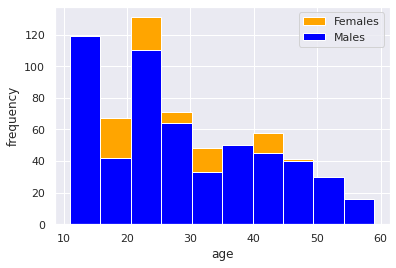

In [ ]:
age_females = np.zeros(nr_females)
age_males = np.zeros(nr_males)
counter_females = 0
counter_males = 0
for k in range (nr_samples_to_be_processed):
  if full_data [k][10][1] == 'FEMALE':
    age_females [counter_females] = year_of_experiment - int(full_data [k][10][2])
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    age_males [counter_males] = year_of_experiment - int(full_data [k][10][2])
    counter_males += 1
plt.hist (age_females, color='orange', label='Females')
#plt.show ()
plt.hist (age_males, color='blue', label='Males')
plt.xlabel ('age') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_age.pdf')


In [ ]:
stat, p = scipy.stats.shapiro(age_females)
print(p)
stat, p = scipy.stats.shapiro(age_males)
print(p)
scipy.stats.mannwhitneyu(age_females, age_males)

1.0529033564075571e-13
3.159943145905966e-14


MannwhitneyuResult(statistic=167856.5, pvalue=0.45223166847910673)

In [ ]:
print ('Mean of females age is',np.mean (age_females))
print ('SD of females age is',np.std (age_females))
print ('Mean of males age is',np.mean (age_males))
print ('SD of males age is',np.std (age_males))

age_all=np.zeros(nr_males+nr_females)
age_all[0:(nr_females)]=age_females
age_all[nr_females:(nr_males+nr_females)]= age_males
print ('Mean of age is', np.mean(age_all))
print ('SD of age is', np.std(age_all))

Mean of females age is 28.412052117263844
SD of females age is 12.331387272949451
Mean of males age is 28.586520947176684
SD of males age is 13.091045915445719
Mean of age is 28.494411006018918
SD of age is 12.695952113233279


##RMS


In [ ]:
def function_RMS (x,y):
    length = 0
    sum = 0
    for k in range(len(x)):
        if k > 0:
            length =(x[k]-x[k-1])**2+(y[k]-y[k-1])**2
            sum = sum + length
    RMS= math.sqrt(sum/len(x))        
    return RMS

def RMS_counter (x,y,step_size,step_move):
    counter=0
    RMS_list = []
    while counter < len(x):
        x_seg = x[counter: counter + step_size]
        y_seg = y[counter: counter + step_size]
        RMS_seg = function_RMS (x_seg,y_seg)
        counter = counter + step_move
        RMS_list.append(RMS_seg)
    return np.array(RMS_list)

def RMS_particiapnts (nr_subjects):
    mean_RMS_all = []
    median_RMS_all = []
    for k in range(nr_subjects):
        x = np.array(full_data [k][0])
        y = np.array(full_data [k][1])
        mean_RMS_all.append(np.mean(RMS_counter (x,y,10,10)))
        median_RMS_all.append( np.median(RMS_counter (x,y,10,10)))
    return np.array(mean_RMS_all), np.array(median_RMS_all)

def pixel_to_visual_angle (nr_pixel):
  d = math.sqrt (16**2 + 9**2)
  x = 27*25.4/d
  a = 16*x
  b = 9* x
  pixel_size_mm = a/1920
  distance_to_screen = 800
  visual_angle = (180/np.pi)* np.arctan(nr_pixel * pixel_size_mm/distance_to_screen)
  return visual_angle

In [ ]:
print ('Mean of RMS is',np.mean(RMS_particiapnts(nr_samples_to_be_processed)[0]))
print ('Median of RMS is', np.median(RMS_particiapnts(nr_samples_to_be_processed)[1]))
print ('STD of RMS is', np.std(RMS_particiapnts(nr_samples_to_be_processed)[0]))

Mean of RMS is 13.663288330395904
Median of RMS is 10.367301131017479
STD of RMS is 3.637000614269242


In [ ]:
# RMS in terms of visual angle 
d = math.sqrt (16**2 + 9**2)
x = 27*25.4/d
a = 16*x
b = 9* x
pixel_size_mm = a/1920
distance_to_screen = 800
print ('Pixel size (mm) is:',pixel_size_mm)
RMS_visual_angle = (180/np.pi)* np.arctan(np.mean(RMS_particiapnts(nr_samples_to_be_processed)[0])*pixel_size_mm/distance_to_screen)
print ('mean RMS value in terms of visual angle:',RMS_visual_angle)
RMS_visual_angle_STD = (180/np.pi)*np.arctan(np.std (RMS_particiapnts(nr_samples_to_be_processed)[0])*pixel_size_mm/distance_to_screen)
print ('STD of the RMS value in terms of visual angle:',RMS_visual_angle_STD)

Pixel size (mm) is: 0.3113158871666749
mean RMS value in terms of visual angle: 0.3046386978461748
STD of the RMS value in terms of visual angle: 0.08109181373263986


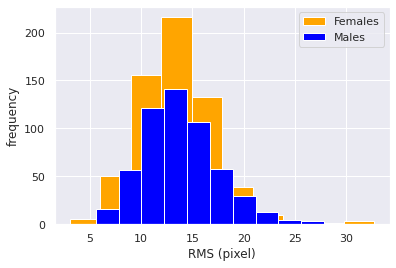

In [ ]:
RMS_females = np.zeros(nr_females)
RMS_males = np.zeros(nr_males)
counter_females = 0
counter_males = 0
RMS_array = RMS_particiapnts(nr_samples_to_be_processed)[0]
for k in range (nr_samples_to_be_processed):
  if full_data [k][10][1] == 'FEMALE':
    RMS_females [counter_females] = RMS_array[k]
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    RMS_males [counter_males] = RMS_array[k]
    counter_males += 1
plt.hist (RMS_females, color='orange', label='Females')
plt.hist (RMS_males, color='blue', label='Males')
plt.xlabel ('RMS (pixel)') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_RMS.pdf')

In [ ]:
print ('mean of RMS for females:',np.mean(RMS_females))
print ('STD of RMS for females:',np.std(RMS_females))

print ('mean of RMS for males:',np.mean(RMS_males))
print ('STD of RMS for males:',np.std(RMS_males))

stat, p = scipy.stats.shapiro(RMS_females)
print('Normality for the RMS of females',p)

stat, p = scipy.stats.shapiro(RMS_males)
print('Normality for the RMS of males',p)

print('Comparison between RMS of males and females')
scipy.stats.mannwhitneyu(RMS_females, RMS_males)

mean of RMS for females: 13.371238422417454
STD of RMS for females: 3.576496991359353
mean of RMS for males: 13.891141149113464
STD of RMS for males: 3.5968568511204904
Normality for the RMS of females 3.149931704360398e-11
Normality for the RMS of males 2.754027491391753e-06
Comparison between RMS of males and females


MannwhitneyuResult(statistic=155316.0, pvalue=0.01035940486464412)

In [ ]:


print ('mean of RMS for females in visual angle:',pixel_to_visual_angle(np.mean(RMS_females)))
print ('STD of RMS for females in visual angle:',pixel_to_visual_angle(np.std(RMS_females)))

print ('mean of RMS for males in visual angle:',pixel_to_visual_angle(np.mean(RMS_males)))
print ('STD of RMS for males in visual angle:',pixel_to_visual_angle(np.std(RMS_males)))



mean of RMS for females in visual angle: 0.2981272287086804
STD of RMS for females in visual angle: 0.07974280595120865
mean of RMS for males in visual angle: 0.30971883984582144
STD of RMS for males in visual angle: 0.08019675578970319


In [ ]:
corr, _ = pearsonr(RMS_females, age_females)
print('Pearson correlation coefficient for females:',corr)

corr, _ = pearsonr(RMS_males, age_males)
print('Pearson correlation coefficient for males:',corr)

X = age_females.reshape(-1,1)
y = RMS_females.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

X = age_males.reshape(-1,1)
y = RMS_males.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

Pearson correlation coefficient for females: 0.018584934421820444
Pearson correlation coefficient for males: -0.08883719592815481
The linear model is: Y = 13.218 + 0.0053902X
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2115
Date:                Mon, 14 Jun 2021   Prob (F-statistic):              0.646
Time:                        07:02:15   Log-Likelihood:                -1653.6
No. Observations:                 614   AIC:                             3311.
Df Residuals:                     612   BIC:                             3320.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

## STD


In [ ]:
def function_STD (x,y):
  sum = 0
  distance = np.zeros(len(x))
  mean_x = np.mean(x,dtype='float64')
  mean_y = np.mean(y,dtype='float64')
  for k in range(len(x)):
    if k > 0:
      distance [k] = math.sqrt((x[k]-mean_x)**2+(y[k]-mean_y)**2)    
  STD = np.std(distance,dtype='float64')
  return STD

def STD_counter (x,y,step_size,step_move):
    counter=0
    STD_list = []
    while counter < len(x):
        x_seg = x[counter: counter + step_size]
        y_seg = y[counter: counter + step_size]
        STD_seg = function_STD(x_seg,y_seg)
        counter = counter + step_move
        STD_list.append(STD_seg)
    return np.array(STD_list)

def STD_particiapnts (nr_subjects):
    mean_STD_all = []
    median_STD_all = []
    for k in range(nr_subjects):
        x = np.array(full_data [k][0])
        y = np.array(full_data [k][1])
        mean_STD_all.append(np.mean(STD_counter (x,y,10,10)))
        median_STD_all.append( np.median(STD_counter (x,y,10,10)))
    return np.array(mean_STD_all), np.array(median_STD_all)

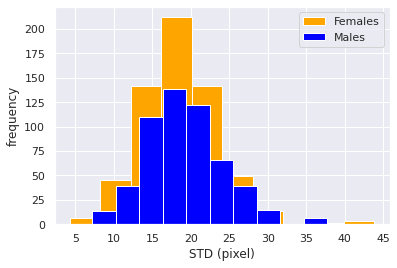

In [ ]:
os. chdir('/content/')
STD_females = np.zeros(nr_females)
STD_males = np.zeros(nr_males)
counter_females = 0
counter_males = 0
STD_array = STD_particiapnts(nr_samples_to_be_processed)[0]
for k in range (nr_samples_to_be_processed):
  if full_data [k][10][1] == 'FEMALE':
    STD_females [counter_females] =STD_array[k]
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    STD_males [counter_males] = STD_array[k]
    counter_males += 1
plt.hist (STD_females, color='orange', label='Females')
plt.hist (STD_males, color='blue', label='Males')
plt.xlabel ('STD (pixel)') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_STD.pdf')

In [ ]:
print ('Mean of STD is', np.mean (STD_particiapnts (nr_samples_to_be_processed)[0]))
print ('Medain of STD is', np.median(STD_particiapnts (nr_samples_to_be_processed)[1]))
print ('STD of STD is', np.std(STD_particiapnts (nr_samples_to_be_processed)[0]))
print ('mean of TSD for females:',np.mean(STD_females))
print ('STD of STD for females:',np.std(STD_females))

print ('mean of STD for males:',np.mean(STD_males))
print ('STD of STD for males:',np.std(STD_males))

stat, p = scipy.stats.shapiro(STD_females)
print('Normality for the STD of females',p)

stat, p = scipy.stats.shapiro(STD_males)
print('Normality for the STD of males',p)

corr, _ = pearsonr(STD_females, age_females)
print('Pearson correlation coefficient for females:',corr)

corr, _ = pearsonr(STD_males, age_males)
print('Pearson correlation coefficient for males:',corr)

print('Comparison between RMS of males and females')
scipy.stats.mannwhitneyu(STD_females, STD_males)
 


Mean of STD is 18.88093081770291
Medain of STD is 13.934530137600294
STD of STD is 4.974325930946664
mean of TSD for females: 18.492712844903355
STD of STD for females: 4.894496669065155
mean of STD for males: 19.197628274849258
STD of STD for males: 4.927656326076447
Normality for the STD of females 2.4294274925118486e-10
Normality for the STD of males 6.799881703045685e-06
Pearson correlation coefficient for females: 0.013636660541673591
Pearson correlation coefficient for males: -0.08981574752231045
Comparison between RMS of males and females


MannwhitneyuResult(statistic=155804.0, pvalue=0.012949345932971423)

## Correlation between peak velocity/distance

In [ ]:
# More information: https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/
def travel_distance (x,y):
    distance = 0
    for k in range (len(x)):
        if k > 0:
            distance = distance + math.sqrt((x[k]-x[k-1])**2+(y[k]-y[k-1])**2)
    return distance

correlation_array = np.zeros (1242)
for k in range (1242):
    velocity = full_data[k][3]
    saccade_positions = full_data[k][8]
    saccade_lengths = full_data[k][9]
    x = full_data[k][0]
    y = full_data[k][1]
    peak_array = np.zeros (len(saccade_positions))
    distance_array = np.zeros (len(saccade_positions))
    for  l in range (len(saccade_positions)):
        start_position = int (saccade_positions [l])
        length = int ( saccade_lengths [l])
        end_position = start_position + length
        velocity_segment = velocity [start_position:end_position]
        peak_array [l] = np.max(velocity_segment)
        x_segment = np.array (x [start_position:end_position])
        y_segment = np.array (y [start_position:end_position])
        distance_array [l] = travel_distance (x_segment,y_segment)
    corr, _ = pearsonr(peak_array, distance_array)
    correlation_array [k] = corr
sum = 0
for m in range (1242):
    sum = sum + correlation_array [k]
mean_correlation_participants = sum/1242
Sigma_corr =0
for n in range (1242):
  Sigma_corr = Sigma_corr + (correlation_array [n]-mean_correlation_participants)**2
SD_correlation_participants = (math.sqrt(Sigma_corr))/1242
print ('mean of participants correlation is',mean_correlation_participants )
print ('SD of participants correlation is',SD_correlation_participants)
#plt.hist(correlation_array)
#plt.xlabel('Pearson''s correlation coefficient')
#plt.ylabel('Frequency')
#plt.show()



mean of participants correlation is 0.8600774112453359
SD of participants correlation is 0.0038140910018761975


In [ ]:
dis_mean_corr = np.abs (correlation_array- mean_correlation_participants)
sort_dis_mean_corr = np.sort (dis_mean_corr,axis =0)
sort_index = np.argsort (dis_mean_corr,axis =0)
#print (sort_dis_mean_corr[0:10])
#print (sort_index[0:10])
list_index = sort_index[0:10].tolist()
for ind in range (len(list_index)):
  k = list_index [ind]
  velocity = full_data[k][3]
  saccade_positions = full_data[k][8]
  saccade_lengths = full_data[k][9]
  x = full_data[k][0]
  y = full_data[k][1]
  peak_array = np.zeros (len(saccade_positions))
  distance_array = np.zeros (len(saccade_positions))
  for  l in range (len(saccade_positions)):
    start_position = int (saccade_positions [l])
    length = int ( saccade_lengths [l])
    end_position = start_position + length
    velocity_segment = velocity [start_position:end_position]
    peak_array [l] = np.max(velocity_segment)
    x_segment = np.array (x [start_position:end_position])
    y_segment = np.array (y [start_position:end_position])
    distance_array [l] = travel_distance (x_segment,y_segment)
    #plt.plot(peak_array, distance_array)
#plt.xlabel('Peak velocity')
#plt.ylabel('Travel distance')

0.8469601243287126


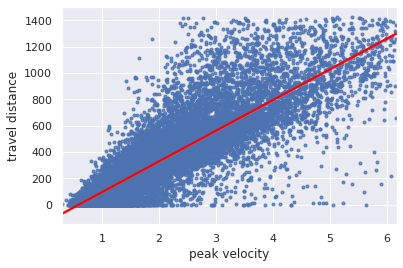

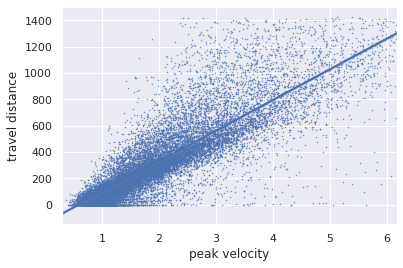

In [ ]:
os. chdir('/content/')
overall_peak = []
overall_distance = []
for k in range (1242):
  velocity = full_data[k][3]
  saccade_positions = full_data[k][8]
  saccade_lengths = full_data[k][9]
  x = full_data[k][0]
  y = full_data[k][1]
  peak_array = np.zeros (len(saccade_positions))
  distance_array = np.zeros (len(saccade_positions))
  for  l in range (len(saccade_positions)):
    start_position = int (saccade_positions [l])
    length = int ( saccade_lengths [l])
    end_position = start_position + length
    velocity_segment = velocity [start_position:end_position]
    peak_array [l] = np.max(velocity_segment)
    x_segment = np.array (x [start_position:end_position])
    y_segment = np.array (y [start_position:end_position])
    distance_array [l] = travel_distance (x_segment,y_segment)
    overall_peak.append(np.max(velocity_segment))
    overall_distance.append (travel_distance (x_segment,y_segment))
filtered_overall_peak = []
filtered_overall_distance = []
peak_threshold = np.mean(overall_peak)+3*np.std(overall_peak)
distance_threshold = np.mean(overall_distance)+3*np.std(overall_distance)

for m in range (len(overall_peak)):
  if overall_peak [m] < peak_threshold and overall_distance [m] < distance_threshold:
    filtered_overall_peak.append (overall_peak [m])
    filtered_overall_distance.append(overall_distance [m])
#sns.regplot(x=overall_peak, y=overall_distance)
#plt.xlabel('Peak velocity')
#plt.ylabel('Travel distance')
#plt.show()
sns.regplot(x=filtered_overall_peak, y=filtered_overall_distance, marker='.', line_kws={"color": "red"})
plt.xlabel('peak velocity')
plt.ylabel('travel distance')
plt.savefig('peak_velocity-travel_distance.pdf')
corr, _ = pearsonr( filtered_overall_peak, filtered_overall_distance)
print(corr)
plt.show()
sns.set_theme()
ax1 = sns.regplot(x=filtered_overall_peak, y=filtered_overall_distance,marker=".",scatter_kws={'s':1})
plt.xlabel('peak velocity')
plt.ylabel('travel distance')
plt.savefig('peak_velocity-travel_distance_1.pdf')


# Gaze event classification

##Otsu

### Fixation

614
549


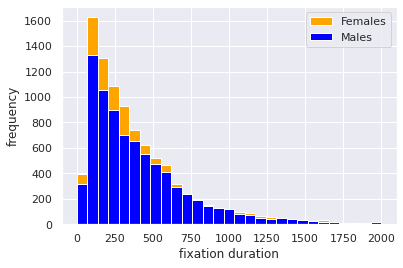

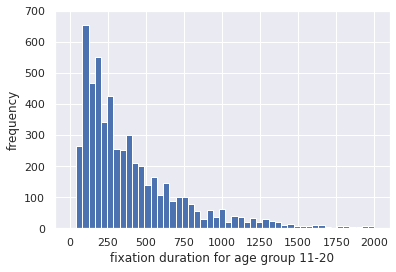

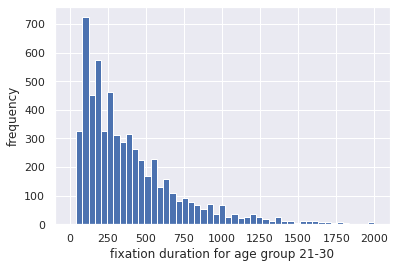

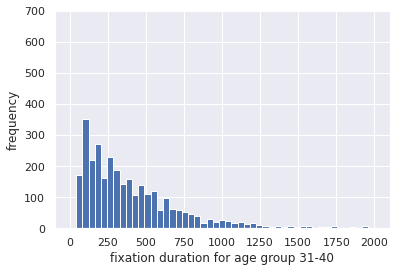

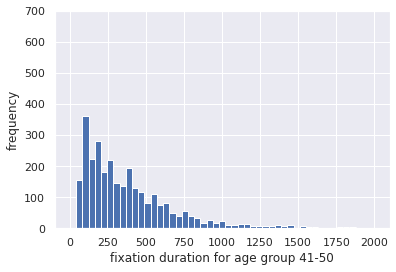

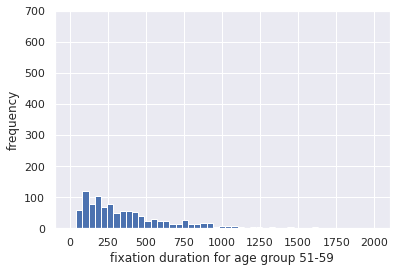

In [ ]:
os. chdir('/content/')
all_fixation_durations = []
all_fixation_durations_male = []
all_fixation_durations_female = []
all_fixation_durations_age_group_11_20 = []
all_fixation_durations_age_group_21_30 = []
all_fixation_durations_age_group_31_40 = []
all_fixation_durations_age_group_41_50 = []
all_fixation_durations_age_group_51_59 = []
mean_fixation_duration_per_participant = np.zeros (nr_samples_to_be_processed)
mean_fixation_duration_female = np.zeros (nr_females)
mean_fixation_duration_male = np.zeros (nr_males)
counter_females = 0
counter_males = 0
for k in range (nr_samples_to_be_processed):
  nr_fixations = len(full_data[k][6])
  this_person_fixation_durations = []
  for l in range (nr_fixations):
    fixation_start = int(full_data[k][6][l])
    fixation_end = int(fixation_start + full_data[k][7][l])
    fixation_time_duration = np.subtract(full_data[k][2][fixation_end],full_data[k][2][fixation_start],dtype='float64')
    this_person_fixation_durations.append(fixation_time_duration)
    if full_data [k][10][1] == 'FEMALE':
      all_fixation_durations.append(fixation_time_duration)
      all_fixation_durations_female.append(fixation_time_duration)
    if full_data [k][10][1] == 'MALE':
      all_fixation_durations_male.append(fixation_time_duration)
      all_fixation_durations.append(fixation_time_duration)
  if full_data [k][10][1] == 'FEMALE':
    mean_fixation_duration_female[counter_females] = np.mean(np.array(this_person_fixation_durations))
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    mean_fixation_duration_male[counter_males] = np.mean(np.array(this_person_fixation_durations))
    counter_males += 1

for k in range (nr_samples_to_be_processed):
  nr_fixations = len(full_data[k][6])
  for l in range (nr_fixations):
    fixation_start = int(full_data[k][6][l])
    fixation_end = int(fixation_start + full_data[k][7][l])
    fixation_time_duration = np.subtract(full_data[k][2][fixation_end],full_data[k][2][fixation_start],dtype='float64')
    if ((10 < year_of_experiment - int(full_data[k][10][2])) and (year_of_experiment - int(full_data[k][10][2]) < 20)):
      all_fixation_durations_age_group_11_20.append(fixation_time_duration)
    if ((20 < year_of_experiment - int(full_data[k][10][2])) and (year_of_experiment - int(full_data[k][10][2]) < 31)):
      all_fixation_durations_age_group_21_30.append(fixation_time_duration)
    if ((30 < year_of_experiment - int(full_data[k][10][2])) and (year_of_experiment - int(full_data[k][10][2]) < 41)):
      all_fixation_durations_age_group_31_40.append(fixation_time_duration)
    if ((40 < year_of_experiment - int(full_data[k][10][2])) and (year_of_experiment - int(full_data[k][10][2]) < 51)):
      all_fixation_durations_age_group_41_50.append(fixation_time_duration)
    if ((50 < year_of_experiment - int(full_data[k][10][2])) and (year_of_experiment - int(full_data[k][10][2]) < 60)):
      all_fixation_durations_age_group_51_59.append(fixation_time_duration)
  mean_fixation_duration_per_participant[k] = np.mean (fixation_time_duration)
print (counter_females)
print(counter_males)
#plt.hist(all_fixation_durations, bins=np.linspace(0,2000,num=100),color='green', label='All')
plt.hist(all_fixation_durations_female,bins=np.linspace(0,2000,num=30), color='orange', label='Females')
plt.hist(all_fixation_durations_male,bins=np.linspace(0,2000,num=30), color='blue', label='Males')
plt.xlabel ('fixation duration') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_fixation_duration_60.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_11_20,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 11-20') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_11_20_otsu_60.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_21_30,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 21-30') 
plt.ylabel ('frequency')
#plt.ylim (0,700)
plt.savefig ('histogram_age_21_30_otsu_60.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_31_40,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 31-40') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_31_40_otsu_60.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_41_50,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 41-50') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_41_50_otsu_60.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_51_59,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 51-59') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_51_59_otsu_60.pdf')


In [ ]:
print ('mean of fixation duration for all:',np.mean(np.array(all_fixation_durations)))
print ('STD of fixation durations for all:',np.std(np.array(all_fixation_durations)))
print ('mean of fixation durations for females:',np.mean(np.array (all_fixation_durations_female)))
print ('STD of fixation durations for females:',np.std(np.array (all_fixation_durations_female)))
print ('mean of fixation durations for males:',np.mean(np.array (all_fixation_durations_male)))
print ('STD of fixation durations for males:',np.std(np.array(all_fixation_durations_male)))

mean of fixation duration for all: 407.39731051344745
STD of fixation durations for all: 417.82462825504524
mean of fixation durations for females: 554.671009771987
STD of fixation durations for females: 640.8209356520666
mean of fixation durations for males: 613.2677595628415
STD of fixation durations for males: 685.0217839719477


In [ ]:
nr_of_fixations = np.zeros (nr_females + nr_males)
gender = np.zeros (nr_females + nr_males)
nr_of_fixations_females = np.zeros (nr_females)
nr_of_fixations_males = np.zeros (nr_males)
counter = 0 
counter_females = 0
counter_males = 0
for k in range (nr_samples_to_be_processed):
    if full_data [k][10][1] == 'FEMALE':
        nr_of_fixations [counter] = len (full_data [k][6])
        nr_of_fixations_females [counter_females] = len (full_data [k][6])
        counter +=1
        counter_females +=1
    elif full_data [k][10][1] == 'MALE':
        nr_of_fixations [counter] = len (full_data [k][6])
        nr_of_fixations_males [counter_males] = len (full_data [k][6])
        counter +=1
        counter_males +=1


mean of nr of fixation for all: 15.072226999140154
STD of nr of fixation for all: 3.2231339368624794
mean of nr of fixation for females: 15.403908794788274
STD of nr of fixation for females: 3.3214902415792773
mean of nr of fixation for males: 14.70127504553734
STD of nr of fixation for males: 3.0672514016859007


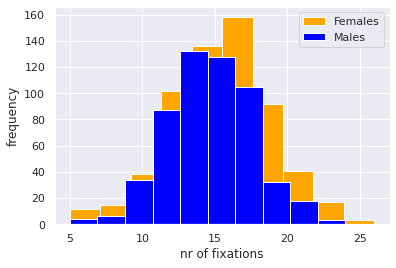

In [ ]:
os. chdir('/content/')
print ('mean of nr of fixation for all:',np.mean(nr_of_fixations))
print ('STD of nr of fixation for all:',np.std (nr_of_fixations))
print ('mean of nr of fixation for females:',np.mean (nr_of_fixations_females))
print ('STD of nr of fixation for females:',np.std(nr_of_fixations_females))
print ('mean of nr of fixation for males:',np.mean(nr_of_fixations_males))
print ('STD of nr of fixation for males:',np.std(nr_of_fixations_males))

plt.hist(nr_of_fixations_females, color='orange', label='Females')
plt.hist(nr_of_fixations_males, color='blue', label='Males')
plt.xlabel ('nr of fixations')
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_nr_fixation_otsu.pdf')


### Threshold

mean of threshold for all: 0.8485372775989964
STD of threshold for all: 0.21551237763437314
mean of threshold for females: 0.8283274477515089
STD of threshold for females: 0.21111228765616302
mean of threshold for males: 0.8643546564929386
STD of threshold for males: 0.2132424788506605


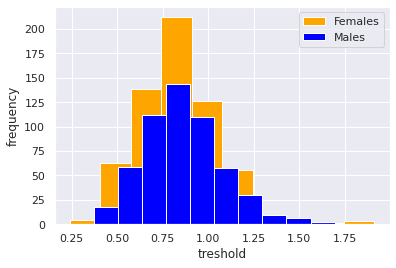

In [ ]:
threshold_females = np.zeros(nr_females)
threshold_males = np.zeros(nr_males)
threshold_all = np.zeros (nr_samples_to_be_processed)
counter_females = 0
counter_males = 0
for k in range (nr_samples_to_be_processed):
  threshold_all [k]= full_data [k][4]
  if full_data [k][10][1] == 'FEMALE':
    threshold_females [counter_females] = full_data [k][4]
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    threshold_males [counter_males] = full_data [k][4]
    counter_males += 1
plt.hist (threshold_females, color='orange', label='Females')
#plt.show ()
plt.hist (threshold_males, color='blue', label='Males')
plt.xlabel ('treshold') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_threshold.pdf')

print ('mean of threshold for all:',np.mean(threshold_all))
print ('STD of threshold for all:',np.std(threshold_all))
print ('mean of threshold for females:',np.mean(threshold_females))
print ('STD of threshold for females:',np.std(threshold_females))
print ('mean of threshold for males:',np.mean(threshold_males))
print ('STD of threshold for males:',np.std(threshold_males))


### saccade

In [ ]:
def peak_saccade_velocity ():
  all_peak_saccade_velocities = []
  for k in range (nr_samples_to_be_processed):
    velocity = full_data[k][3]
    saccade_positions = full_data[k][8]
    saccade_lengths = full_data[k][9]
    x = full_data[k][0]
    y = full_data[k][1]
    peak_array = np.zeros (len(saccade_positions))
    distance_array = np.zeros (len(saccade_positions))
    for  l in range (len(saccade_positions)):
      start_position = int (saccade_positions [l])
      length = int ( saccade_lengths [l])
      end_position = start_position + length
      velocity_segment = velocity [start_position:end_position]
      peak_array [l] = np.max(velocity_segment)
    all_peak_saccade_velocities.append(peak_array)
  return all_peak_saccade_velocities 


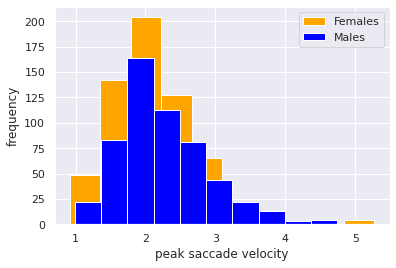

In [ ]:
peak_saccade_velocity_females = np.zeros(nr_females)
peak_saccade_velocity_males = np.zeros(nr_males)
peak_saccade_velocity_all = np.zeros (nr_samples_to_be_processed)
counter_females = 0
counter_males = 0
all_saccades = peak_saccade_velocity()
for k in range (nr_samples_to_be_processed):
  peak_saccade_velocity_all[k]= np.mean(all_saccades[k])
  if full_data [k][10][1] == 'FEMALE':
    peak_saccade_velocity_females [counter_females] = np.mean(all_saccades[k])
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    peak_saccade_velocity_males [counter_males] = np.mean(all_saccades[k])
    counter_males += 1
plt.hist (peak_saccade_velocity_females, color='orange', label='Females')
plt.hist (peak_saccade_velocity_males, color='blue', label='Males')
plt.xlabel ('peak saccade velocity') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_peak_saccade_velocity.pdf')

In [ ]:
print ('mean of peak saccade velocity for all:',np.mean(peak_saccade_velocity_all))
print ('STD of peak saccade velocity for all:',np.std(peak_saccade_velocity_all))
print ('mean of peak saccade velocity for females:',np.mean(peak_saccade_velocity_females))
print ('STD of peak saccade velocity for females:',np.std(peak_saccade_velocity_females))
print ('mean of peak saccade velocity for males:',np.mean(peak_saccade_velocity_males))
print ('STD of peak saccade velocity for males:',np.std(peak_saccade_velocity_males))

mean of peak saccade velocity for all: 2.1610586825003097
STD of peak saccade velocity for all: 0.6086829019999064
mean of peak saccade velocity for females: 2.072367634215996
STD of peak saccade velocity for females: 0.587902741789991
mean of peak saccade velocity for males: 2.2242687592784978
STD of peak saccade velocity for males: 0.6067782875707635


In [ ]:
def travel_distance (x,y):
    distance = 0
    for k in range (len(x)):
        if k > 0:
            distance = distance + math.sqrt((x[k]-x[k-1])**2+(y[k]-y[k-1])**2)
    return distance
mean_saccade_distance_per_participant = np.zeros (nr_samples_to_be_processed)
mean_saccade_duration_per_participant = np.zeros (nr_samples_to_be_processed)
nr_saccade_per_participant = np.zeros (nr_samples_to_be_processed)
for k in range (nr_samples_to_be_processed):
  nr_saccade = np.shape (full_data [k][8])
  saccade_positions = full_data [k][8]
  saccade_lengths = full_data [k][9]
  nr_saccade_per_participant [k] = len(full_data [k][8])
  x = full_data [k][0]
  y = full_data [k][1]
  time = full_data [k][2]
  peak_array = np.zeros (len(saccade_positions))
  distance_array = np.zeros (len(saccade_positions))
  saccade_duration = np.zeros (len(saccade_positions))
  for  l in range (len(saccade_positions)):
    start_position = np.int64 (saccade_positions [l])
    length = np.int64 ( saccade_lengths [l])
    end_position = start_position + length
    x_segment = np.array (x [start_position:end_position])
    y_segment = np.array (y [start_position:end_position])
    distance_array [l] = travel_distance (x_segment,y_segment)
    saccade_duration [l] = time [end_position]- time [start_position]
  mean_saccade_duration_per_participant[k] = np.mean (saccade_duration)
  mean_saccade_distance_per_participant[k] = np.mean (distance_array)

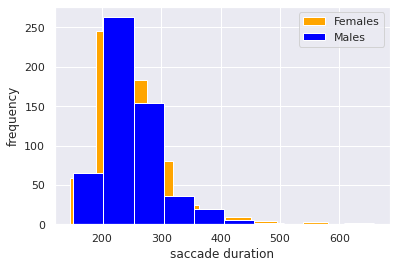

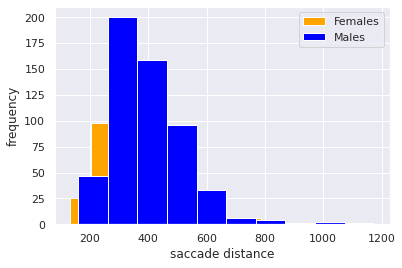

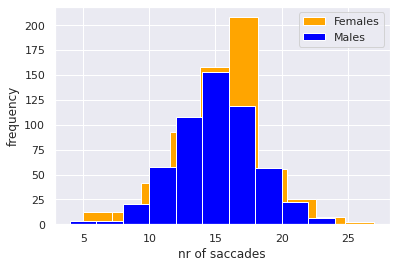

In [ ]:
os. chdir('/content/')
saccade_duration_females = np.zeros(nr_females)
saccade_duration_males = np.zeros(nr_males)
saccade_duration_all = np.zeros (nr_samples_to_be_processed)
saccade_distance_females = np.zeros(nr_females)
saccade_distance_males = np.zeros(nr_males)
saccade_distance_all = np.zeros (nr_samples_to_be_processed)
nr_saccade_females = np.zeros(nr_females)
nr_saccade_males = np.zeros(nr_males)
nr_saccade_all = np.zeros (nr_samples_to_be_processed)
counter_females = 0
counter_males = 0
for k in range (nr_samples_to_be_processed):
  saccade_duration_all [k] = mean_saccade_duration_per_participant[k]
  saccade_distance_all [k] = mean_saccade_distance_per_participant[k]
  nr_saccade_all [k] = nr_saccade_per_participant [k]
  if full_data [k][10][1] == 'FEMALE':
    saccade_duration_females [counter_females] = mean_saccade_duration_per_participant[k]
    saccade_distance_females [counter_females] = mean_saccade_distance_per_participant[k]
    nr_saccade_females [counter_females] = nr_saccade_per_participant [k]
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    saccade_duration_males [counter_males] = mean_saccade_duration_per_participant[k]
    saccade_distance_males [counter_males] = mean_saccade_distance_per_participant[k]
    nr_saccade_males [counter_males] = nr_saccade_per_participant [k]
    counter_males += 1
plt.hist (saccade_duration_females, color='orange', label='Females')
plt.hist (saccade_duration_males, color='blue', label='Males')
plt.xlabel ('saccade duration') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_saccade_duration.pdf')
plt.show ()
plt.hist (saccade_distance_females, color='orange', label='Females')
plt.hist (saccade_distance_males, color='blue', label='Males')
plt.xlabel ('saccade distance') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_saccade_distance.pdf')
plt.show ()
plt.hist (nr_saccade_females, color='orange', label='Females')
plt.hist (nr_saccade_males, color='blue', label='Males')
plt.xlabel ('nr of saccades') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('nr_saccade.pdf')

In [ ]:
print ('mean of saccade duration for all is:',np.mean(saccade_duration_all))
print ('STD of saccade duration for all is:',np.std(saccade_duration_all))
print ('mean of saccade duration for females is:',np.mean(saccade_duration_females))
print ('STD of saccade duration for females is:',np.std(saccade_duration_females))
print ('mean of saccade duration for males is:',np.mean(saccade_duration_males))
print ('STD of saccade duration for males:',np.std(saccade_duration_males))

mean of saccade duration for all is: 235.6983556641271
STD of saccade duration for all is: 53.71630459102136
mean of saccade duration for females is: 231.57082458443742
STD of saccade duration for females is: 54.35893830438544
mean of saccade duration for males is: 239.12939830840705
STD of saccade duration for males: 52.301840550733424


In [ ]:
print ('mean of saccade distance for all is:',np.mean(saccade_distance_all))
print ('STD of saccade distance for all is:',np.std(saccade_distance_all))
print ('mean of saccade distance for females is:',np.mean(saccade_distance_females))
print ('STD of saccade distance for females is:',np.std(saccade_distance_females))
print ('mean of saccade distance for males is:',np.mean(saccade_distance_males))
print ('STD of saccade distance for males:',np.std(saccade_distance_males))

mean of saccade distance for all is: 362.54030776188034
STD of saccade distance for all is: 112.86720911635838
mean of saccade distance for females is: 344.6505862723236
STD of saccade distance for females is: 108.296937907947
mean of saccade distance for males is: 376.67663496831915
STD of saccade distance for males: 113.83246206679522


In [ ]:
print ('mean of nr of saccade for all is:',np.mean(nr_saccade_all))
print ('STD of nr of saccade for all is:',np.std(nr_saccade_all))
print ('mean of nr of saccade for females is:',np.mean(nr_saccade_females))
print ('STD of nr of saccade for females is:',np.std(nr_saccade_females))
print ('mean of nr of saccade for males is:',np.mean(nr_saccade_males))
print ('STD of nr of saccade for males:',np.std(nr_saccade_males))

mean of nr of saccade for all is: 15.652979066022544
STD of nr of saccade for all is: 3.4642682591306904
mean of nr of saccade for females is: 16.063517915309447
STD of nr of saccade for females is: 3.5414076410797355
mean of nr of saccade for males is: 15.293260473588342
STD of nr of saccade for males: 3.225520125451784


### correlation

In [ ]:
age_all = np.zeros (nr_samples_to_be_processed)
for k in range (nr_samples_to_be_processed):
  age_all [k] = year_of_experiment - int(full_data [k][10][2])

age_all_male_and_female = np.zeros (nr_females + nr_males)
counter = 0 
for k in range (nr_samples_to_be_processed):
  if full_data [k][10][1] == 'FEMALE':
    age_all_male_and_female [counter] = year_of_experiment - int(full_data [k][10][2])
    counter += 1
  if full_data [k][10][1] == 'MALE':
    age_all_male_and_female[counter] = year_of_experiment - int(full_data [k][10][2])
    counter += 1


In [ ]:
stat, p = scipy.stats.shapiro(threshold_females)
print('Normality for the threshold of females',p)

stat, p = scipy.stats.shapiro(threshold_males)
print('Normality for the threshold of males',p)

corr, _ = pearsonr(threshold_all, age_all)
print('Pearson correlation coefficient for threshold vs age:',corr)

corr, _ = pearsonr(threshold_females, age_females)
print('Pearson correlation coefficient for threshold of females vs age:',corr)

corr, _ = pearsonr(threshold_males, age_males)
print('Pearson correlation for threshold of males vs age:',corr)

print('Comparison between threshold of males and females')
scipy.stats.mannwhitneyu(threshold_females, threshold_males)


Normality for the threshold of females 1.8210692676046136e-10
Normality for the threshold of males 4.474570687307278e-06
Pearson correlation coefficient for threshold vs age: -0.03428209066602262
Pearson correlation coefficient for threshold of females vs age: 0.018516249560105072
Pearson correlation for threshold of males vs age: -0.08083891251564332
Comparison between threshold of males and females


MannwhitneyuResult(statistic=152967.0, pvalue=0.0032261319234886793)

In [ ]:
stat, p = scipy.stats.shapiro(nr_of_fixations_females)
print('Normality for the nr of fixations of females',p)

stat, p = scipy.stats.shapiro(nr_of_fixations_males)
print('Normality for the nr of fixations of males',p)

corr, _ = pearsonr(nr_of_fixations, age_all_male_and_female)
print('Pearson correlation coefficient for nr of fixations vs age:',corr)

corr, _ = pearsonr(nr_of_fixations_females, age_females)
print('Pearson correlation coefficient for nr of fixations of females vs age:',corr)

corr, _ = pearsonr(nr_of_fixations_males, age_males)
print('Pearson correlation for nr of fixations of males vs age:',corr)

print('Comparison between nr of fixations of males and females')
scipy.stats.mannwhitneyu(nr_of_fixations_females, nr_of_fixations_males)


Normality for the nr of fixations of females 2.14482206501998e-05
Normality for the nr of fixations of males 0.0003466422203928232
Pearson correlation coefficient for nr of fixations vs age: 0.08006066724645773
Pearson correlation coefficient for nr of fixations of females vs age: 0.12607193865409688
Pearson correlation for nr of fixations of males vs age: 0.02940579943087742
Comparison between nr of fixations of males and females


MannwhitneyuResult(statistic=147007.0, pvalue=7.767434315413572e-05)

In [ ]:
stat, p = scipy.stats.shapiro(np.array(all_fixation_durations_female))
print('Normality for the fixation duration of females',p)

stat, p = scipy.stats.shapiro(all_fixation_durations_male)
print('Normality for the fixation duration of males',p)

corr, _ = pearsonr(mean_fixation_duration_per_participant, age_all)
print('Pearson correlation coefficient for fixation duration vs age:',corr)

corr, _ = pearsonr( mean_fixation_duration_female, age_females)
print('Pearson correlation coefficient for fixation duration of females vs age:',corr)

corr, _ = pearsonr( mean_fixation_duration_male, age_males)
print('Pearson correlation for fixation duration of males vs age:',corr)

print('Comparison between fixation duration of males and females')
scipy.stats.mannwhitneyu(all_fixation_durations_female, all_fixation_durations_male)


Normality for the fixation duration of females 1.6079302167517996e-32
Normality for the fixation duration of males 7.331762519977006e-30
Pearson correlation coefficient for fixation duration vs age: -0.05416741564614519
Pearson correlation coefficient for fixation duration of females vs age: -0.10962168378295827
Pearson correlation for fixation duration of males vs age: 0.02649794885604731
Comparison between fixation duration of males and females


MannwhitneyuResult(statistic=158421.0, pvalue=0.03834797730925268)

In [ ]:
stat, p = scipy.stats.shapiro(threshold_females)
print('Normality for the threshold of females',p)

stat, p = scipy.stats.shapiro(threshold_males)
print('Normality for the threshold of males',p)

corr, _ = pearsonr(threshold_all, age_all)
print('Pearson correlation coefficient for threshold vs age:',corr)

corr, _ = pearsonr(threshold_females, age_females)
print('Pearson correlation coefficient for threshold of females vs age:',corr)

corr, _ = pearsonr(threshold_males, age_males)
print('Pearson correlation for threshold of males vs age:',corr)

print('Comparison between threshold of males and females')
scipy.stats.mannwhitneyu(threshold_females, threshold_males)


Normality for the threshold of females 1.8210692676046136e-10
Normality for the threshold of males 4.474570687307278e-06
Pearson correlation coefficient for threshold vs age: -0.03428209066602262
Pearson correlation coefficient for threshold of females vs age: 0.018516249560105072
Pearson correlation for threshold of males vs age: -0.08083891251564332
Comparison between threshold of males and females


MannwhitneyuResult(statistic=152967.0, pvalue=0.0032261319234886793)

In [ ]:
stat, p = scipy.stats.shapiro(peak_saccade_velocity_females)
print('Normality for the peak saccade velocity of females',p)

stat, p = scipy.stats.shapiro(peak_saccade_velocity_males)
print('Normality for the peak saccade velocity of males',p)

corr, _ = pearsonr(peak_saccade_velocity_all, age_all)
print('Pearson correlation coefficient for peak saccade velocity vs age:',corr)

corr, _ = pearsonr(peak_saccade_velocity_females, age_females)
print('Pearson correlation coefficient for peak saccade velocity of females vs age:',corr)

corr, _ = pearsonr(peak_saccade_velocity_males, age_males)
print('Pearson correlation for peak saccade velocity of males vs age:',corr)

print('Comparison between peak saccade velocity of males and females')
scipy.stats.mannwhitneyu(peak_saccade_velocity_females, peak_saccade_velocity_males)

Normality for the peak saccade velocity of females 1.0412106976102572e-15
Normality for the peak saccade velocity of males 4.419637832792089e-12
Pearson correlation coefficient for peak saccade velocity vs age: -0.07860982336321702
Pearson correlation coefficient for peak saccade velocity of females vs age: -0.059226237269374336
Pearson correlation for peak saccade velocity of males vs age: -0.089789028054581
Comparison between peak saccade velocity of males and females


MannwhitneyuResult(statistic=144420.0, pvalue=1.2292392601665425e-05)

In [ ]:
print (np.shape(saccade_duration_all)[0])

1242


In [ ]:
stat, p = scipy.stats.shapiro(saccade_duration_females)
print('Normality for the saccade duration of females',p)

stat, p = scipy.stats.shapiro(saccade_duration_males)
print('Normality for the saccade duration of males',p)

corr, _ = pearsonr(saccade_duration_all, age_all)
print('Pearson correlation coefficient for saccade duration vs age:',corr)

corr, _ = pearsonr(saccade_duration_females, age_females)
print('Pearson correlation coefficient for saccade duration of females vs age:',corr)

corr, _ = pearsonr(saccade_duration_males, age_males)
print('Pearson correlation for saccade duration of males vs age:',corr)

print('Comparison between saccade duration of males and females')
scipy.stats.mannwhitneyu(saccade_duration_females, saccade_duration_males)

Normality for the saccade duration of females 3.414960616293327e-25
Normality for the saccade duration of males 1.2543740362791726e-23
Pearson correlation coefficient for saccade duration vs age: -0.09185086206449031
Pearson correlation coefficient for saccade duration of females vs age: -0.13825742597909013
Pearson correlation for saccade duration of males vs age: -0.0470962898238882
Comparison between saccade duration of males and females


MannwhitneyuResult(statistic=148238.0, pvalue=0.00019197186117434354)

In [ ]:
stat, p = scipy.stats.shapiro(saccade_distance_females)
print('Normality for the saccade distance of females',p)

stat, p = scipy.stats.shapiro(saccade_distance_males)
print('Normality for the saccade distance of males',p)

corr, _ = pearsonr(saccade_distance_all, age_all)
print('Pearson correlation coefficient for saccade distance vs age:',corr)

corr, _ = pearsonr(saccade_distance_females, age_females)
print('Pearson correlation coefficient for saccade distance of females vs age:',corr)

corr, _ = pearsonr(saccade_distance_males, age_males)
print('Pearson correlation for saccade distance of males vs age:',corr)

print('Comparison between saccade distance of males and females')
scipy.stats.mannwhitneyu(saccade_distance_females, saccade_distance_males)

Normality for the saccade distance of females 2.180579596554842e-15
Normality for the saccade distance of males 1.1577882921271198e-16
Pearson correlation coefficient for saccade distance vs age: -0.10792095842893118
Pearson correlation coefficient for saccade distance of females vs age: -0.10636269612179325
Pearson correlation for saccade distance of males vs age: -0.11240229484696426
Comparison between saccade distance of males and females


MannwhitneyuResult(statistic=138637.0, pvalue=8.479282402980056e-08)

In [ ]:
stat, p = scipy.stats.shapiro(nr_saccade_females)
print('Normality for the nr of saccades of females',p)

stat, p = scipy.stats.shapiro(nr_saccade_males)
print('Normality for the nr of saccades of males',p)

corr, _ = pearsonr(nr_saccade_all, age_all)
print('Pearson correlation coefficient for nr of saccades vs age:',corr)

corr, _ = pearsonr(nr_saccade_females, age_females)
print('Pearson correlation coefficient for nr of saccades of females vs age:',corr)

corr, _ = pearsonr(nr_saccade_males, age_males)
print('Pearson correlation for nr of saccades of males vs age:',corr)

print('Comparison between nr of saccades of males and females')
scipy.stats.mannwhitneyu(nr_saccade_females, nr_saccade_males)

Normality for the nr of saccades of females 5.607541879726341e-06
Normality for the nr of saccades of males 0.0007681168499402702
Pearson correlation coefficient for nr of saccades vs age: 0.07340625942858545
Pearson correlation coefficient for nr of saccades of females vs age: 0.12224847279607691
Pearson correlation for nr of saccades of males vs age: 0.02987564627072804
Comparison between nr of saccades of males and females


MannwhitneyuResult(statistic=145267.5, pvalue=2.1735740028960618e-05)

## I2MC

### fixation


In [ ]:
total_fixation_duration = np.zeros(nr_samples_to_be_processed)
age_i2mc_all = []
age_i2mc_females = []
age_i2mc_males = []
all_fixation_durations_i2mc = []
all_fixation_durations_male_i2mc = []
all_fixation_durations_female_i2mc = []
all_fixation_durations_age_group_11_20 = []
all_fixation_durations_age_group_21_30 = []
all_fixation_durations_age_group_31_40 = []
all_fixation_durations_age_group_41_50 = []
all_fixation_durations_age_group_51_59 = []


for k in range (nr_samples_to_be_processed):
  if (I2MC_data[k] !={}):
    fix= I2MC_data[k]
    age = year_of_experiment - int(full_data[k][10][2])
    age_i2mc_all.append(age)
    if full_data [k][10][1] == 'FEMALE':
      age_i2mc_females.append(age)
    if full_data [k][10][1] == 'MALE':
      age_i2mc_males.append(age)
age_i2mc_array_all = np.array(age_i2mc_all)
age_i2mc_array_females = np.array(age_i2mc_females)
age_i2mc_array_males = np.array(age_i2mc_males)


mean_all_fixation_durations_i2mc = np.zeros (np.shape(age_i2mc_array_all)[0])
mean_all_fixation_durations_female_i2mc = np.zeros (np.shape(age_i2mc_array_females)[0])
mean_all_fixation_durations_male_i2mc = np.zeros (np.shape(age_i2mc_array_males)[0])
counter = 0
counter_females = 0
counter_males = 0

for k in range (nr_samples_to_be_processed):
  if (I2MC_data[k] !={}):
    fix= I2MC_data[k]
    age = year_of_experiment - int(full_data[k][10][2])
    for l in range(len(fix['start'])):
      fixation_time_duration = np.subtract(fix['endT'][l],fix['startT'][l],dtype = 'int64')
      if ((10 < age) and (age < 20)):
        all_fixation_durations_age_group_11_20.append(fixation_time_duration)
      if ((20 < age) and (age < 31)):
        all_fixation_durations_age_group_21_30.append(fixation_time_duration)
      if ((30 < age) and (age < 41)):
        all_fixation_durations_age_group_31_40.append(fixation_time_duration)
      if ((40 < age) and (age < 51)):
        all_fixation_durations_age_group_41_50.append(fixation_time_duration)
      if ((50 < age) and (age < 60)):
        all_fixation_durations_age_group_51_59.append(fixation_time_duration)
    if full_data [k][10][1] == 'FEMALE':
      mean_all_fixation_durations_female_i2mc = np.mean (np.array(all_fixation_durations_female_i2mc))
      counter_females += 1
    if full_data [k][10][1] == 'MALE':
      mean_all_fixation_durations_male_i2mc = np.mean (np.array(all_fixation_durations_male_i2mc))
      counter_males += 1
   

mean_all_fixation_durations_i2mc = np.zeros (np.shape(age_i2mc_array_all)[0])
mean_all_fixation_durations_female_i2mc = np.zeros (np.shape(age_i2mc_array_females)[0])
mean_all_fixation_durations_male_i2mc = np.zeros (np.shape(age_i2mc_array_males)[0])
counter = 0
counter_females = 0
counter_males = 0

for k in range (nr_samples_to_be_processed):
  if (I2MC_data[k] !={}):
    fix= I2MC_data[k]
    age = year_of_experiment - int(full_data[k][10][2])
    for l in range(len(fix['start'])):
      fixation_time_duration = np.subtract(fix['endT'][l],fix['startT'][l],dtype = 'int64')
      all_fixation_durations_i2mc.append(fixation_time_duration)
    mean_all_fixation_durations_i2mc[counter] = np.mean (np.array(all_fixation_durations_i2mc))
    counter += 1
    if full_data [k][10][1] == 'FEMALE':
      for l in range(len(fix['start'])):
        fixation_time_duration = np.subtract(fix['endT'][l],fix['startT'][l],dtype = 'int64')
        all_fixation_durations_female_i2mc.append(fixation_time_duration)
      mean_all_fixation_durations_female_i2mc [counter_females] = np.mean (np.array(all_fixation_durations_female_i2mc))
      counter_females += 1
    if full_data [k][10][1] == 'MALE':
      for l in range(len(fix['start'])):
        fixation_time_duration = np.subtract(fix['endT'][l],fix['startT'][l],dtype = 'int64')
        all_fixation_durations_male_i2mc.append(fixation_time_duration)
      mean_all_fixation_durations_male_i2mc [counter_males] = np.mean (np.array(all_fixation_durations_male_i2mc))
      counter_males += 1

      



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


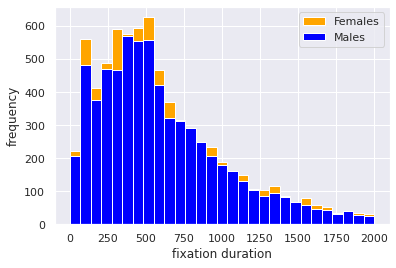

In [ ]:
#plt.hist(all_fixation_durations_i2mc, bins=np.linspace(0,2000,num=100),color='green', label='All')
plt.hist(all_fixation_durations_female_i2mc,bins=np.linspace(0,2000,num=30), color='orange', label='Females')
plt.hist(all_fixation_durations_male_i2mc,bins=np.linspace(0,2000,num=30), color='blue', label='Males')
plt.xlabel ('fixation duration') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_fixation_duration_I2MC_60.pdf')

In [ ]:
plt.hist(all_fixation_durations_female_i2mc,bins=np.linspace(0,2000,num=100), color='orange', label='Females')
plt.hist(all_fixation_durations_male_i2mc,bins=np.linspace(0,2000,num=100), color='green', label='Males')
plt.xlabel ('fixation duration') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_fixation_duration_I2MC.pdf')

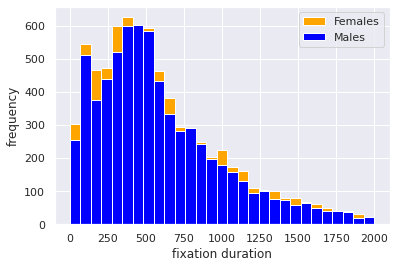

In [ ]:
plt.hist(all_fixation_durations_female_i2mc,bins=np.linspace(0,2000,num=30), color='orange', label='Females')
plt.hist(all_fixation_durations_male_i2mc,bins=np.linspace(0,2000,num=30), color='blue', label='Males')
plt.xlabel ('fixation duration') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_fixation_duration_I2MC_gender.pdf')

In [ ]:
print ('mean of fixation duration for all:',np.mean(np.array(all_fixation_durations_i2mc)))
print ('STD of fixation durations for all:',np.std(np.array(all_fixation_durations_i2mc)))
print ('mean of fixation durations for females:',np.mean(np.array (all_fixation_durations_female_i2mc)))
print ('STD of fixation durations for females:',np.std(np.array (all_fixation_durations_female_i2mc)))
print ('mean of fixation durations for males:',np.mean(np.array (all_fixation_durations_male_i2mc)))
print ('STD of fixation durations for males:',np.std(np.array(all_fixation_durations_male_i2mc)))

mean of fixation duration for all: 643.1120706198426
STD of fixation durations for all: 530.1745257964684
mean of fixation durations for females: 651.6309119414685
STD of fixation durations for females: 543.7727114667074
mean of fixation durations for males: 638.5261578044597
STD of fixation durations for males: 520.8557718043327


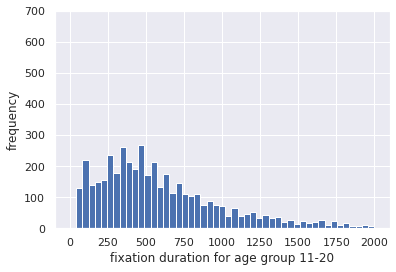

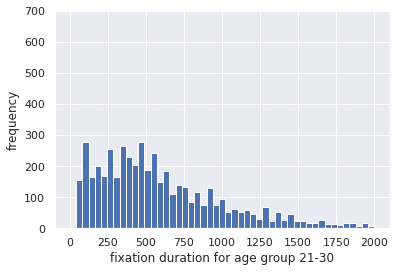

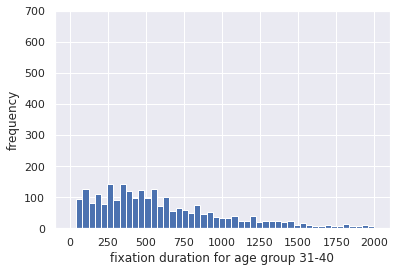

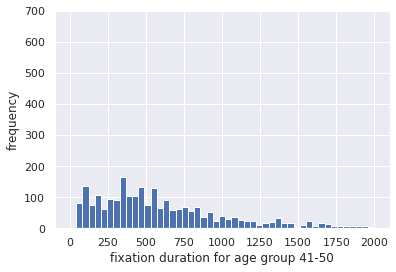

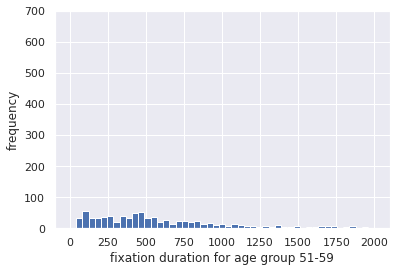

In [ ]:
os. chdir('/content/')
plt.hist(all_fixation_durations_age_group_11_20,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 11-20') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_11_20_I2MC.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_21_30,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 21-30') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_21_30_I2MC.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_31_40,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 31-40') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_31_40_I2MC.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_41_50,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 41-50') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age_41_50_I2MC.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_51_59,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration for age group 51-59') 
plt.ylabel ('frequency')
plt.ylim (0,700)
plt.savefig ('histogram_age__51_59_I2MC.pdf')


In [ ]:
nr_fixation_i2mc_all = np.zeros (np.shape(age_i2mc_array_all)[0])
nr_fixation_i2mc_females = np.zeros(np.shape(age_i2mc_array_females)[0])
nr_fixation_i2mc_males = np.zeros(np.shape(age_i2mc_array_males)[0])
counter = 0
counter_females = 0
counter_males = 0 
for k in range (nr_samples_to_be_processed):
  if (I2MC_data[k] !={}):
    fix= I2MC_data[k]
    nr_fixation_i2mc_all [counter]= np.shape (fix['start'])[0]
    counter += 1 
    if full_data [k][10][1] == 'FEMALE':
      nr_fixation_i2mc_females [counter_females] = np.shape (fix['start'])[0]
      counter_females += 1   
    if full_data [k][10][1] == 'MALE':
      nr_fixation_i2mc_males [counter_males] = np.shape (fix['start'])[0]
      counter_males += 1 

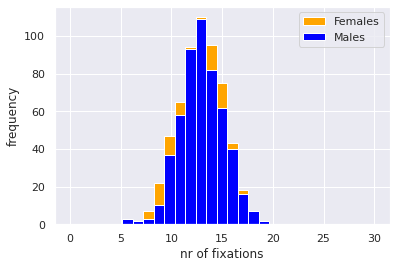

In [ ]:
os. chdir('/content/')
plt.hist(nr_fixation_i2mc_females,bins=np.linspace(0,30,num=30), color='orange', label='Females')
plt.hist(nr_fixation_i2mc_males,bins=np.linspace(0,30,num=30), color='blue', label='Males')
plt.xlabel ('nr of fixations') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_nr_fixation_I2MC.pdf')

In [ ]:
print ('mean of nr of fixation for all is:',np.mean(nr_fixation_all_i2mc))
print ('STD of nr of fixation for all is:',np.std(nr_fixation_all_i2mc))
print ('mean of nr of fixation for females is:',np.mean(nr_fixation_females_i2mc))
print ('STD of nr of fixation for females is:',np.std(nr_fixation_females_i2mc))
print ('mean of nr of fixation for males is:',np.mean(nr_fixation_males_i2mc))
print ('STD of nr of fixation for males:',np.std(nr_fixation_males_i2mc))

mean of nr of fixation for all is: 12.58695652173913
STD of nr of fixation for all is: 3.660634992350914
mean of nr of fixation for females is: 12.465798045602606
STD of nr of fixation for females is: 3.675072681804186
mean of nr of fixation for males is: 12.743169398907105
STD of nr of fixation for males: 3.4664110049815235


### corellation

In [ ]:
stat, p = scipy.stats.shapiro(nr_fixation_i2mc_females)
print('Normality for the nr of fixations of females',p)

stat, p = scipy.stats.shapiro(nr_fixation_i2mc_males)
print('Normality for the nr of fixations of males',p)

corr, _ = pearsonr(nr_fixation_i2mc_all, age_i2mc_array_all)
print('Pearson correlation coefficient for nr of fixations vs age:',corr)

corr, _ = pearsonr(nr_fixation_i2mc_females, age_i2mc_array_females)
print('Pearson correlation coefficient for nr of fixations of females vs age:',corr)

corr, _ = pearsonr(nr_fixation_i2mc_males, age_i2mc_array_males)
print('Pearson correlation for nr of fixations of males vs age:',corr)

print('Comparison between nr of fixations of males and females')
scipy.stats.mannwhitneyu(nr_fixation_i2mc_females, nr_fixation_i2mc_males)

Normality for the nr of fixations of females 7.800135222169047e-07
Normality for the nr of fixations of males 1.0043937237469436e-07
Pearson correlation coefficient for nr of fixations vs age: -0.05087463414166367
Pearson correlation coefficient for nr of fixations of females vs age: -0.018088777411892094
Pearson correlation for nr of fixations of males vs age: -0.058396504067899146
Comparison between nr of fixations of males and females


MannwhitneyuResult(statistic=143812.0, pvalue=0.05438526573680967)

In [ ]:
stat, p = scipy.stats.shapiro(mean_all_fixation_durations_female_i2mc)
print('Normality for the nr of fixations of females',p)

stat, p = scipy.stats.shapiro(mean_all_fixation_durations_male_i2mc)
print('Normality for the nr of fixations of males',p)

corr, _ = pearsonr(mean_all_fixation_durations_i2mc, age_i2mc_array_all)
print('Pearson correlation coefficient forfixation durations vs age:',corr)

corr, _ = pearsonr(mean_all_fixation_durations_female_i2mc, age_i2mc_array_females)
print('Pearson correlation coefficient for fixation durations of females vs age:',corr)

corr, _ = pearsonr(mean_all_fixation_durations_male_i2mc, age_i2mc_array_males)
print('Pearson correlation for fixation durations of males vs age:',corr)

print('Comparison between nr of fixations of males and females')
scipy.stats.mannwhitneyu(mean_all_fixation_durations_male_i2mc, mean_all_fixation_durations_female_i2mc)

Normality for the nr of fixations of females 1.1766663995640687e-28
Normality for the nr of fixations of males 2.071681692997599e-32
Pearson correlation coefficient for nr of fixations vs age: 0.037598521453650655
Pearson correlation coefficient for nr of fixations of females vs age: 0.0772991475628952
Pearson correlation for nr of fixations of males vs age: -0.0040189367530300635
Comparison between nr of fixations of males and females


MannwhitneyuResult(statistic=76143.0, pvalue=4.466579702820484e-47)

## Christoph's

### Fixation

In [ ]:
os. chdir('/content/')

all_fixation_durations = []
all_fixation_durations_male = []
all_fixation_durations_female = []
all_fixation_durations_age_group_11_20 = []
all_fixation_durations_age_group_21_30 = []
all_fixation_durations_age_group_31_40 = []
all_fixation_durations_age_group_41_50 = []
all_fixation_durations_age_group_51_59 = []
mean_fixation_duration_per_participant = np.zeros (nr_samples_to_be_processed)
mean_fixation_duration_female = np.zeros (nr_females)
mean_fixation_duration_male = np.zeros (nr_males)
counter_females = 0
counter_males = 0
for k in range (nr_samples_to_be_processed):
  nr_fixations = full_data_chris[0][k]
  if full_data [k][10][1] == 'FEMALE':
    all_fixation_durations.append (full_data_chris[1][k])
    all_fixation_durations_female.append(full_data_chris[1][k])
    #mean_fixation_duration_female[counter_females] = full_data_chris[1][k]
    counter_females += 1
  if full_data [k][10][1] == 'MALE':
    all_fixation_durations.append (full_data_chris[1][k])
    all_fixation_durations_male.append(full_data_chris[1][k])
    #mean_fixation_duration_male[counter_males] = full_data_chris[1][k]
    counter_males += 1

for k in range (nr_samples_to_be_processed):
  nr_fixations = full_data_chris[0][k]
  age = year_of_experiment - int(full_data[k][10][2])
  if ((10 < age) and (age < 20)):
    all_fixation_durations_age_group_11_20.append(full_data_chris[1][k])
  if ((20 < age) and (age < 31)):
    all_fixation_durations_age_group_21_30.append(full_data_chris[1][k])
  if ((30 < age) and (age < 41)):
    all_fixation_durations_age_group_31_40.append(full_data_chris[1][k])
  if ((40 < age) and (age < 51)):
    all_fixation_durations_age_group_41_50.append(full_data_chris[1][k])
  if ((50 < age) and (age < 60)):
    all_fixation_durations_age_group_51_59.append(full_data_chris[1][k])
  mean_fixation_duration_per_participant[k] = full_data_chris[1][k]

#plt.hist(all_fixation_durations, bins=np.linspace(0,2000,num=100),color='green', label='All')
plt.hist(all_fixation_durations_female,bins=np.linspace(0,2000,num=30),color= 'orange', label='Females')
plt.hist(all_fixation_durations_male,bins=np.linspace(0,2000,num=30), color='blue', label='Males')
plt.xlabel ('fixation duration') 
plt.ylabel ('frequency')
plt.legend()
plt.savefig ('histogram_fixation_duration_chris.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_11_20,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration_age 11_20') 
plt.ylabel ('frequency')
#plt.ylim (0,700)
plt.savefig ('histogram_age_11_20_chris.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_21_30,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration_age 21_30') 
plt.ylabel ('frequency')
#plt.ylim (0,700)
plt.savefig ('histogram_age_21_30_chris.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_31_40,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration_age 31_40') 
plt.ylabel ('frequency')
#plt.ylim (0,700)
plt.savefig ('histogram_age_31_40_chris.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_41_50,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration_age 41_50') 
plt.ylabel ('frequency')
#plt.ylim (0,700)
plt.savefig ('histogram_age_41_50_chris.pdf')
plt.show()
plt.hist(all_fixation_durations_age_group_51_59,bins=np.linspace(0,2000,num=50))
plt.xlabel ('fixation duration_age 51_59') 
plt.ylabel ('frequency')
#plt.ylim (0,700)
plt.savefig ('histogram_age_51_59_chris.pdf')


In [ ]:
print ('mean of fixation duration for all:',np.mean(np.array(all_fixation_durations)))
print ('STD of fixation durations for all:',np.std(np.array(all_fixation_durations)))
print ('mean of fixation durations for females:',np.mean(np.array (all_fixation_durations_female)))
print ('STD of fixation durations for females:',np.std(np.array (all_fixation_durations_female)))
print ('mean of fixation durations for males:',np.mean(np.array (all_fixation_durations_male)))
print ('STD of fixation durations for males:',np.std(np.array(all_fixation_durations_male)))

mean of fixation duration for all: 244.91643095787322
STD of fixation durations for all: 104.85730466019953
mean of fixation durations for females: 247.3721285922474
STD of fixation durations for females: 115.54250214916466
mean of fixation durations for males: 242.1699858804493
STD of fixation durations for males: 91.36150453976431


# Predictive models

## Classic machine learning

### OTSU

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import glob, os
import numpy as np
import math
from skimage import data
from skimage.filters import threshold_otsu
import cv2
import os.path
from os import path
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pickle

sns.set_theme()



In [ ]:
nr_samples_to_be_processed = 1242
nr_females = 614
nr_males =  549

threshold = np.zeros(nr_females + nr_males)
nr_of_fixations = np.zeros (nr_females + nr_males)
gender = np.zeros (nr_females + nr_males)
age = np.zeros (nr_females + nr_males)
age_females = np.zeros (nr_females)
age_males = np.zeros (nr_males)
threshold_females = np.zeros (nr_females)
threshold_males = np.zeros (nr_males)
nr_of_fixations_females = np.zeros (nr_females)
nr_of_fixations_males = np.zeros (nr_males)

year_of_experiment = 2020
counter = 0 
counter_females = 0
counter_males = 0

for k in range (nr_samples_to_be_processed):
    if full_data[k][10][1] == 'FEMALE':
        threshold [counter] = full_data[k][4]
        gender [counter] = 1
        age[counter] = year_of_experiment-int (full_data[k][10][2])
        nr_of_fixations [counter] = len (full_data[k][6])
        age_females [counter_females] = year_of_experiment-int (full_data[k][10][2])
        threshold_females [counter_females] = full_data[k][4]
        nr_of_fixations_females [counter_females] = len (full_data[k][6])
        counter +=1
        counter_females +=1
    elif full_data[k][10][1] == 'MALE':
        threshold [counter] = full_data[k][4]
        gender [counter] = 2
        age[counter] = year_of_experiment-int (full_data[k][10][2])
        nr_of_fixations [counter] = len (full_data[k][6])
        age_males [counter_males] = year_of_experiment-int (full_data[k][10][2])
        threshold_males [counter_males] = full_data[k][4]
        nr_of_fixations_males [counter_males] = len (full_data[k][6])
        counter +=1
        counter_males +=1

In [ ]:
nr_samples_to_be_processed = 1242
nr_females = 614
nr_males =  549

gender = np.zeros (nr_females + nr_males)
age = np.zeros (nr_females + nr_males)
age_females = np.zeros (nr_females)
age_males = np.zeros (nr_males)
fixation_time_duration_females = np.zeros (nr_females)
fixation_time_duration_males = np.zeros (nr_males)
fixation_time_duration = np.zeros (nr_females + nr_males)


year_of_experiment = 2020
counter = 0 
counter_females = 0
counter_males = 0

for k in range (nr_samples_to_be_processed):
    if full_data[k][10][1] == 'FEMALE':
        gender [counter] = 1
        age[counter] = year_of_experiment-int (full_data[k][10][2])
        nr_of_fixations_d = len (full_data[k][6])
        fixation_time_duration_for_k = np.zeros(nr_of_fixations_d)
        for l in range (nr_of_fixations_d):
          fixation_start = int(full_data[k][6][l])
          fixation_end = int(fixation_start + full_data[k][7][l])
          fixation_time_duration_for_k [l] = np.subtract(full_data[k][2][fixation_end],full_data[k][2][fixation_start],dtype='float64')
        fixation_time_duration [counter]= np.mean(fixation_time_duration_for_k)
        fixation_time_duration_females [counter_females] = np.mean(fixation_time_duration_for_k)
        age_females [counter_females] = year_of_experiment-int (full_data[k][10][2])
        counter +=1
        counter_females +=1
    elif full_data[k][10][1] == 'MALE':
        gender [counter] = 2
        age[counter] = year_of_experiment-int (full_data[k][10][2])
        nr_of_fixations_d = len (full_data[k][6])
        fixation_time_duration_for_k = np.zeros(nr_of_fixations_d)
        for l in range (nr_of_fixations_d):
          fixation_start = int(full_data[k][6][l])
          fixation_end = int(fixation_start + full_data[k][7][l])
          fixation_time_duration_for_k [l] = np.subtract(full_data[k][2][fixation_end],full_data[k][2][fixation_start],dtype='float64')
        fixation_time_duration [counter]= np.mean(fixation_time_duration_for_k)
        fixation_time_duration_males [counter_males] = np.mean(fixation_time_duration_for_k)
        age_males [counter_males] = year_of_experiment-int (full_data[k][10][2])
        counter +=1
        counter_males +=1


In [ ]:
def travel_distance (x,y):
    distance = 0
    for k in range (len(x)):
        if k > 0:
            distance = distance + math.sqrt((x[k]-x[k-1])**2+(y[k]-y[k-1])**2)
    return distance
mean_saccade_distance_per_participant = np.zeros (nr_samples_to_be_processed)
mean_saccade_duration_per_participant = np.zeros (nr_samples_to_be_processed)
nr_saccade_per_participant = np.zeros (nr_samples_to_be_processed)
for k in range (nr_samples_to_be_processed):
  nr_saccade = np.shape (full_data [k][8])
  saccade_positions = full_data[k][8]
  saccade_lengths = full_data [k][9]
  nr_saccade_per_participant [k] = len(full_data [k][8])
  x = full_data [k][0]
  y = full_data [k][1]
  time = full_data [k][2]
  peak_array = np.zeros (len(saccade_positions))
  distance_array = np.zeros (len(saccade_positions))
  saccade_duration = np.zeros (len(saccade_positions))
  for  l in range (len(saccade_positions)):
    start_position = np.int64 (saccade_positions [l])
    length = np.int64 ( saccade_lengths [l])
    end_position = start_position + length
    x_segment = np.array (x [start_position:end_position])
    y_segment = np.array (y [start_position:end_position])
    distance_array [l] = travel_distance (x_segment,y_segment)
    saccade_duration [l] = time [end_position]- time [start_position]
  mean_saccade_duration_per_participant[k] = np.mean (saccade_duration)
  mean_saccade_distance_per_participant[k] = np.mean (distance_array)

In [ ]:
saccade_duration_females = np.zeros(nr_females)
saccade_duration_males = np.zeros(nr_males)
saccade_duration_all = np.zeros (nr_samples_to_be_processed)
saccade_distance_females = np.zeros(nr_females)
saccade_distance_males = np.zeros(nr_males)
saccade_distance_all = np.zeros (nr_samples_to_be_processed)
nr_saccade_females = np.zeros(nr_females)
nr_saccade_males = np.zeros(nr_males)
nr_saccade_all = np.zeros (nr_samples_to_be_processed)
saccade_duration =[]
saccade_distance =[]
counter_females = 0
counter_males = 0
for k in range (nr_samples_to_be_processed):
  saccade_duration_all [k] = mean_saccade_duration_per_participant[k]
  saccade_distance_all [k] = mean_saccade_distance_per_participant[k]
  nr_saccade_all [k] = nr_saccade_per_participant [k]
  if full_data[k][10][1] == 'FEMALE':
    saccade_duration_females [counter_females] = mean_saccade_duration_per_participant[k]
    saccade_distance_females [counter_females] = mean_saccade_distance_per_participant[k]
    nr_saccade_females [counter_females] = nr_saccade_per_participant [k]
    saccade_duration.append (mean_saccade_duration_per_participant[k])
    saccade_distance.append (mean_saccade_distance_per_participant[k])
    counter_females += 1
  if full_data[k][10][1] == 'MALE':
    saccade_duration_males [counter_males] = mean_saccade_duration_per_participant[k]
    saccade_distance_males [counter_males] = mean_saccade_distance_per_participant[k]
    nr_saccade_males [counter_males] = nr_saccade_per_participant [k]
    saccade_duration.append (mean_saccade_duration_per_participant[k])
    saccade_distance.append (mean_saccade_distance_per_participant[k])
    counter_males += 1

(1163, 2)
Mean Absolute Error: 12.76923076923077
Mean Squared Error: 251.26495726495727
Root Mean Squared Error: 15.85133928931424


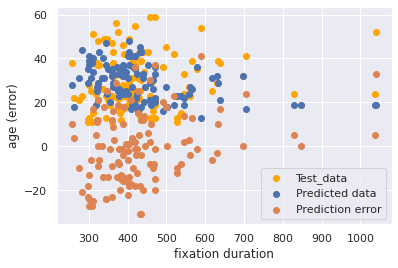

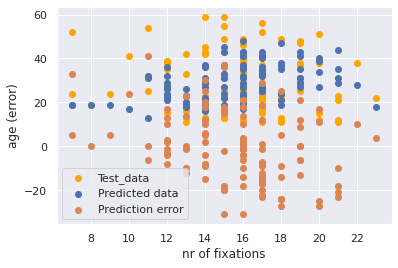

In [ ]:
# More information: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
os. chdir('/content')

X = np.vstack((nr_of_fixations, fixation_time_duration)).T
print(np.shape(X))
y = age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred_round = np.around (y_pred,0)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_round))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_round))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_round)))
X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,1],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred_round, label='Prediction error')
plt.xlabel('fixation duration')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_fix_duration_age_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,0],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred_round, label='Prediction error')
plt.xlabel('nr of fixations')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_nr_fix_age_otsu.pdf')


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
os. chdir('/content')

X = np.vstack((nr_of_fixations, fixation_time_duration)).T
print(np.shape(X))
y = gender
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred_round = np.around (y_pred,0)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_round))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_round))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_round)))
X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,1],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred_round, label='Prediction error')
plt.xlabel('fixation duration')
plt.ylabel('gender')
plt.legend()
plt.savefig('prediction_fix_duration_gender_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,0],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred_round, label='Prediction error')
plt.xlabel('nr of fixations')
plt.ylabel('gender')
plt.legend()
plt.savefig('prediction_nr_fix_gender_otsu.pdf')


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
os. chdir('/content')

X = np.vstack((saccade_duration,saccade_distance)).T
print(np.shape(X))
y = age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,1],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred, label='Prediction error')
plt.xlabel('saccade distance')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_saccade_distance_age_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,0],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred, label='Prediction error')
plt.xlabel('saccade duration')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_saccade_duration_age_otsu.pdf')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
os. chdir('/content')

X = np.vstack((saccade_duration,saccade_distance)).T
print(np.shape(X))
y = gender
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred_round = np.around (y_pred,0)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_round))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_round))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_round)))
X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,1],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred_round, label='Prediction error')
plt.xlabel('saccade duration')
plt.ylabel('gender')
plt.legend()
plt.savefig('prediction_saccade_duration_gender_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,0],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred_round, label='Prediction error')
plt.xlabel('saccade distance')
plt.ylabel('gender')
plt.legend()
plt.savefig('prediction_saccade_distance_gender_otsu.pdf')


(1163, 4)
Mean Absolute Error: 10.322222222222221
Mean Squared Error: 162.66992402659073
Root Mean Squared Error: 12.754212011198133


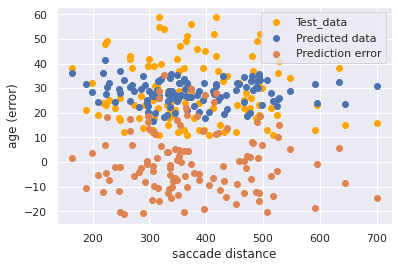

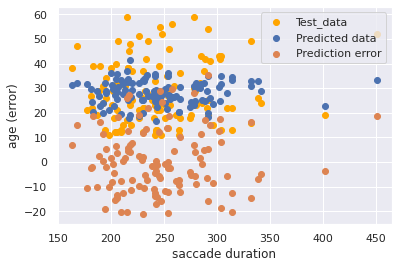

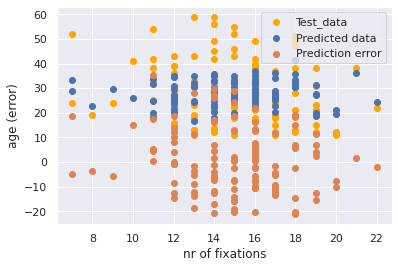

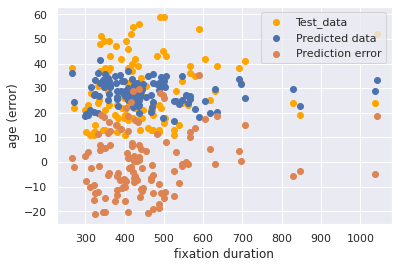

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
os. chdir('/content')

X = np.vstack((saccade_duration,saccade_distance,nr_of_fixations, fixation_time_duration)).T
print(np.shape(X))
y = age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,1],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred, label='Prediction error')
plt.xlabel('saccade distance')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_saccade_distance_age_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,0],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred, label='Prediction error')
plt.xlabel('saccade duration')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_saccade_duration_age_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,2],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,2],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,2],y_test-y_pred, label='Prediction error')
plt.xlabel('nr of fixations')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_nr_fixation_age_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,3],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,3],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,3],y_test-y_pred, label='Prediction error')
plt.xlabel('fixation duration')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_fixation_duration_age_otsu.pdf')



(1163, 4)
Mean Absolute Error: 0.4749287749287749
Mean Squared Error: 0.2615859449192782
Root Mean Squared Error: 0.5114547339885303


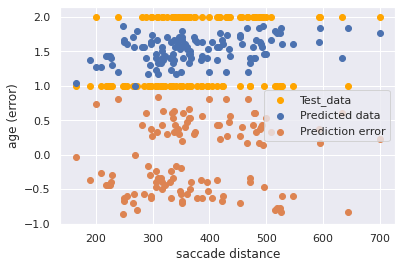

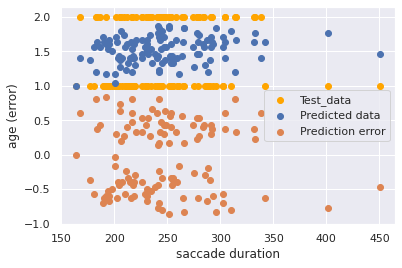

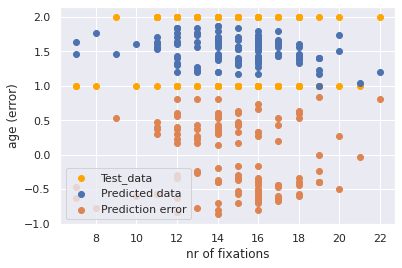

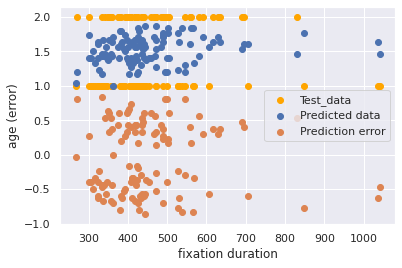

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
os. chdir('/content')

X = np.vstack((saccade_duration,saccade_distance,nr_of_fixations, fixation_time_duration)).T
print(np.shape(X))
y = gender
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,1],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred, label='Prediction error')
plt.xlabel('saccade distance')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_saccade_distance_gender_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,0],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred, label='Prediction error')
plt.xlabel('saccade duration')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_saccade_duration_gender_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,2],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,2],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,2],y_test-y_pred, label='Prediction error')
plt.xlabel('nr of fixations')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_nr_fixation_gender_otsu.pdf')
plt.show()
plt.scatter(X_test_original[:,3],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,3],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,3],y_test-y_pred, label='Prediction error')
plt.xlabel('fixation duration')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_all_fixation_duration_gender_otsu.pdf')



In [ ]:
# More information: https://seaborn.pydata.org/generated/seaborn.regplot.html
import seaborn as sns
sns.set_theme()
ax1 = sns.regplot(x=nr_of_fixations_females,y = age_females,marker=".",scatter_kws={'s':2} ,robust = True,label='females')
#plt.show()
ax2 = sns.regplot(x=nr_of_fixations_males,y = age_males,marker=".",scatter_kws={'s':2}, robust = True, label='males')
plt.xlabel('nr of fixations')
plt.ylabel('age')
plt.legend()
plt.savefig('regression_nr_fix_age_otsu.pdf')  

In [ ]:
import seaborn as sns
sns.set_theme()
#ax = sns.regplot(x=age_females, y=threshold_females)
ax1 = sns.regplot(x=threshold_females,y = age_females, marker=".",scatter_kws={'s':2},robust = True,label='females')
#plt.show()
ax2 = sns.regplot(x=threshold_males,y = age_males, marker = ".",scatter_kws={'s':2}, robust = True,label='males')
plt.xlabel('threshold')
plt.ylabel('age')
plt.legend()
plt.savefig('regression_threshold_age_otsu.pdf')

In [ ]:
import seaborn as sns
sns.set_theme()
#ax = sns.regplot(x=age_females, y=threshold_females)
ax1 = sns.regplot(x=fixation_time_duration_females,y =age_females, marker=".",scatter_kws={'s':2},robust = True,label='females')
#plt.show()
ax2 = sns.regplot(x=fixation_time_duration_males,y =age_males, marker = ".",scatter_kws={'s':2}, robust = True,label='males')
plt.xlabel('fixation duration')
plt.ylabel('age')
plt.legend()
plt.savefig('regression_fixation_duration_age_otsu.pdf')

### I2MC

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import glob, os
import numpy as np
import math
from skimage import data
from skimage.filters import threshold_otsu
import cv2
import os.path
from os import path
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pickle

sns.set_theme()


In [ ]:
nr_samples_to_be_processed = 1242
nr_females = 614
nr_males =  549
year_of_experiment = 2020

total_fixation_duration = np.zeros(nr_samples_to_be_processed)
age_i2mc_all = []
age_i2mc_females = []
age_i2mc_males = []
age_i2mc = []
all_fixation_durations_i2mc = []
all_fixation_durations_male_i2mc = []
all_fixation_durations_female_i2mc = []
fixation_duration_i2mc = []
gender_i2mc = []
for k in range (nr_samples_to_be_processed):
  if (I2MC_data[k] !={}):
    fix= I2MC_data[k]
    age = year_of_experiment - int(full_data[k][10][2])
    age_i2mc_all.append(age)
    if full_data [k][10][1] == 'FEMALE':
      age_i2mc_females.append(age)
      age_i2mc.append(age)
      gender_i2mc.append(1)
    if full_data [k][10][1] == 'MALE':
      age_i2mc_males.append(age)
      age_i2mc.append(age)
      gender_i2mc.append(2)
age_i2mc_array_all = np.array(age_i2mc_all)
age_i2mc_array_females = np.array(age_i2mc_females)
age_i2mc_array_males = np.array(age_i2mc_males)
   
mean_all_fixation_durations_i2mc = np.zeros (np.shape(age_i2mc_array_all)[0])
mean_all_fixation_durations_female_i2mc = np.zeros (np.shape(age_i2mc_array_females)[0])
mean_all_fixation_durations_male_i2mc = np.zeros (np.shape(age_i2mc_array_males)[0])
counter = 0
counter_females = 0
counter_males = 0

for k in range (nr_samples_to_be_processed):
  if (I2MC_data[k] !={}):
    fix= I2MC_data[k]
    age = year_of_experiment - int(full_data[k][10][2])
    for l in range(len(fix['start'])):
      fixation_time_duration = np.subtract(fix['endT'][l],fix['startT'][l],dtype = 'int64')
      all_fixation_durations_i2mc.append(fixation_time_duration)
    mean_all_fixation_durations_i2mc[counter] = np.mean (np.array(all_fixation_durations_i2mc))
    counter += 1
    if full_data [k][10][1] == 'FEMALE':
      for l in range(len(fix['start'])):
        fixation_time_duration = np.subtract(fix['endT'][l],fix['startT'][l],dtype = 'int64')
        all_fixation_durations_female_i2mc.append(fixation_time_duration)
      mean_all_fixation_durations_female_i2mc [counter_females] = np.mean (np.array(all_fixation_durations_female_i2mc))
      fixation_duration_i2mc.append (np.mean (np.array(all_fixation_durations_female_i2mc)))
      counter_females += 1
    if full_data [k][10][1] == 'MALE':
      for l in range(len(fix['start'])):
        fixation_time_duration = np.subtract(fix['endT'][l],fix['startT'][l],dtype = 'int64')
        all_fixation_durations_male_i2mc.append(fixation_time_duration)
      mean_all_fixation_durations_male_i2mc [counter_males] = np.mean (np.array(all_fixation_durations_male_i2mc))
      fixation_duration_i2mc.append (np.mean (np.array(all_fixation_durations_male_i2mc)))
      counter_males += 1
#print (np.shape(fixation_duration_i2mc))
     



In [ ]:
nr_fixation_i2mc_all = np.zeros (np.shape(age_i2mc_array_all)[0])
nr_fixation_i2mc_females = np.zeros(np.shape(age_i2mc_array_females)[0])
nr_fixation_i2mc_males = np.zeros(np.shape(age_i2mc_array_males)[0])
nr_fixation_i2mc = np.zeros(np.shape(age_i2mc_array_females)[0] + np.shape(age_i2mc_array_males)[0])
counter = 0
counter_females = 0
counter_males = 0 
for k in range (nr_samples_to_be_processed):
  if (I2MC_data[k] !={}):
    fix= I2MC_data[k]
    nr_fixation_i2mc_all [counter]= np.shape (fix['start'])[0]
    counter += 1 
    if full_data [k][10][1] == 'FEMALE':
      nr_fixation_i2mc_females [counter_females] = np.shape (fix['start'])[0]
      nr_fixation_i2mc [counter_females] = np.shape (fix['start'])[0] 
      counter_females += 1   
    if full_data [k][10][1] == 'MALE':
      nr_fixation_i2mc_males [counter_males] = np.shape (fix['start'])[0]
      nr_fixation_i2mc [counter_males] = np.shape (fix['start'])[0]
      counter_males += 1 
#print(np.shape(nr_fixation_i2mc))

(1105, 2)
Mean Absolute Error: 12.36196196196196
Mean Squared Error: 237.72924035146255
Root Mean Squared Error: 15.41847075268694


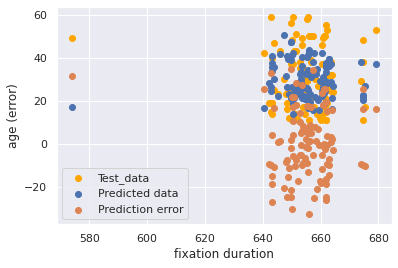

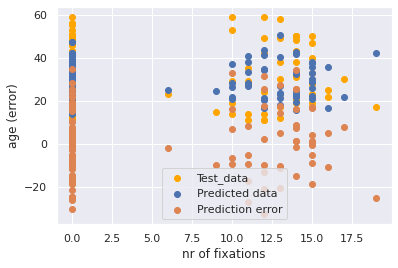

In [ ]:
# More information: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
#os. chdir('/content')

X = np.vstack((nr_fixation_i2mc, fixation_duration_i2mc)).T
print(np.shape(X))
y = age_i2mc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,1],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred, label='Prediction error')
plt.xlabel('fixation duration')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_fix_duration_age_i2mc.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange', label='Test_data')
plt.scatter(X_test_original[:,0],y_pred, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred, label='Prediction error')
plt.xlabel('nr of fixations')
plt.ylabel('age (error)')
plt.legend()
plt.savefig('prediction_nr_fix_age_i2mc.pdf')


(1105, 2)
Mean Absolute Error: 0.11711711711711711
Mean Squared Error: 0.11711711711711711
Root Mean Squared Error: 0.34222378222022665


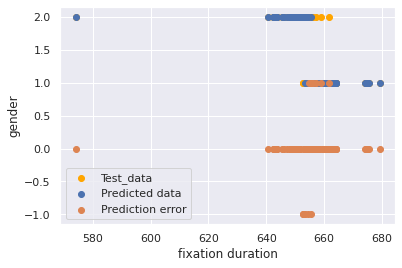

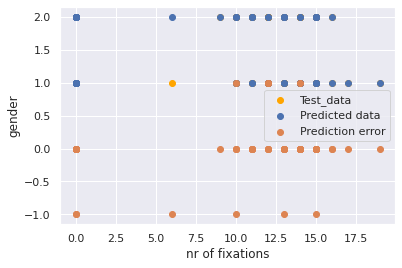

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
os. chdir('/content')

X = np.vstack((nr_fixation_i2mc, fixation_duration_i2mc)).T
print(np.shape(X))
y = gender_i2mc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred_round = np.around (y_pred,0)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_round))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_round))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_round)))

X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test_original[:,1],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,1],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,1],y_test-y_pred_round, label='Prediction error')
plt.xlabel('fixation duration')
plt.ylabel('gender')
plt.legend()
plt.savefig('prediction_fix_duration_gender_i2mc.pdf')
plt.show()
plt.scatter(X_test_original[:,0],y_test,color='orange',label='Test_data')
plt.scatter(X_test_original[:,0],y_pred_round, label='Predicted data')
plt.scatter(X_test_original[:,0],y_test-y_pred_round, label='Prediction error')
plt.xlabel('nr of fixations')
plt.ylabel('gender')
plt.legend()
plt.savefig('prediction_nr_fix_gender_i2mc.pdf')

In [ ]:
# More information: https://seaborn.pydata.org/generated/seaborn.regplot.html
import seaborn as sns
sns.set_theme()
ax1 = sns.regplot(x=nr_fixation_i2mc_females,y = age_i2mc_females,marker=".",scatter_kws={'s':2} ,robust = True,label='females')
#plt.show()
ax2 = sns.regplot(x=nr_fixation_i2mc_males,y = age_i2mc_males,marker=".",scatter_kws={'s':2}, robust = True,label='males')
plt.xlabel('nr of fixations')
plt.ylabel('age')
plt.legend()
plt.savefig('regression_nr_fix_age_i2mc.pdf')

In [ ]:
import seaborn as sns
sns.set_theme()

ax1 = sns.regplot(x=mean_all_fixation_durations_female_i2mc,y =age_i2mc_females, marker=".",scatter_kws={'s':2},robust = True,label='females')
#plt.show()
ax2 = sns.regplot(x=mean_all_fixation_durations_male_i2mc,y =age_i2mc_males, marker = ".",scatter_kws={'s':2}, robust = True,label='males')
plt.xlabel('fixation duration')
plt.ylabel('age')
plt.legend()
plt.savefig('regression_fixation_duration_age_i2mc.pdf')
plt.savefig('figure4.pdf')

## Deep learning

### Using features as the input

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import glob, os
import numpy as np
import math
from skimage import data
from skimage.filters import threshold_otsu
import cv2
import os.path
from os import path
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import metrics

from google.colab import drive
drive.mount('/content/gdrive')
import os
os. chdir('/content/gdrive/MyDrive/full data_polished_2')

sns.set_theme()

subprocess.run('clear')

# *************************************
# *************************************
# Parameters
max_nr_samples = 4
nr_samples_to_be_processed = 4
year_of_experiment = 2020
min_size_fixations = 250 # Minimum number of data points
nr_females = 614
nr_males =  549

filename='full_data'
infile = open(filename,'rb')
full_data = pickle.load(infile)
infile.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### OTSU

In [ ]:
nr_samples_to_be_processed = 1242
nr_females = 614
nr_males =  549

threshold = np.zeros(nr_females + nr_males)
nr_of_fixations = np.zeros (nr_females + nr_males)
gender = np.zeros (nr_females + nr_males)
age = np.zeros (nr_females + nr_males)
age_females = np.zeros (nr_females)
age_males = np.zeros (nr_males)
threshold_females = np.zeros (nr_females)
threshold_males = np.zeros (nr_males)
nr_of_fixations_females = np.zeros (nr_females)
nr_of_fixations_males = np.zeros (nr_males)
fixation_time_duration_females = np.zeros (nr_females)
fixation_time_duration_males = np.zeros (nr_males)
fixation_time_duration = np.zeros (nr_females + nr_males)

year_of_experiment = 2020
counter = 0 
counter_females = 0
counter_males = 0

for k in range (nr_samples_to_be_processed):
    if full_data[k][10][1] == 'FEMALE':
        threshold [counter] = full_data[k][4]
        gender [counter] = 1
        age[counter] = year_of_experiment-int (full_data[k][10][2])
        nr_of_fixations [counter] = len (full_data[k][6])
        age_females [counter_females] = year_of_experiment-int (full_data[k][10][2])
        threshold_females [counter_females] = full_data[k][4]
        nr_of_fixations_females [counter_females] = len (full_data[k][6])
        nr_of_fixations_d = len (full_data[k][6])
        fixation_time_duration_for_k = np.zeros(nr_of_fixations_d)
        for l in range (nr_of_fixations_d):
          fixation_start = int(full_data[k][6][l])
          fixation_end = int(fixation_start + full_data[k][7][l])
          fixation_time_duration_for_k [l] = np.subtract(full_data[k][2][fixation_end],full_data[k][2][fixation_start],dtype='float64')
        fixation_time_duration [counter]= np.mean(fixation_time_duration_for_k)
        fixation_time_duration_females [counter_females] = np.mean(fixation_time_duration_for_k)
        counter +=1
        counter_females +=1
    elif full_data[k][10][1] == 'MALE':
        threshold [counter] = full_data[k][4]
        gender [counter] = 2
        age[counter] = year_of_experiment-int (full_data[k][10][2])
        nr_of_fixations [counter] = len (full_data[k][6])
        age_males [counter_males] = year_of_experiment-int (full_data[k][10][2])
        threshold_males [counter_males] = full_data[k][4]
        nr_of_fixations_males [counter_males] = len (full_data[k][6])
        nr_of_fixations_d = len (full_data[k][6])
        fixation_time_duration_for_k = np.zeros(nr_of_fixations_d)
        for l in range (nr_of_fixations_d):
          fixation_start = int(full_data[k][6][l])
          fixation_end = int(fixation_start + full_data[k][7][l])
          fixation_time_duration_for_k [l] = np.subtract(full_data[k][2][fixation_end],full_data[k][2][fixation_start],dtype='float64')
        fixation_time_duration [counter]= np.mean(fixation_time_duration_for_k)
        fixation_time_duration_males [counter_males] = np.mean(fixation_time_duration_for_k)
        counter +=1
        counter_males +=1

In [ ]:
X = np.vstack((fixation_time_duration,nr_of_fixations)).T  
y = np.vstack((gender, age)).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

n_features = X_train.shape[1]
print(n_features)

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)
output = Dense(2)(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit(X_train, y_train, batch_size=5, epochs=100, verbose=2, validation_split=0.1)

y_pred_train = model.predict(X_train)
#print(np.shape(pred_train))
#print(np.shape(y_train))
print(np.sqrt(mean_squared_error(y_train[:,1],y_pred_train[:,1])))

y_pred = model.predict(X_test)
#print(np.shape(pred))
print(np.sqrt(mean_squared_error(y_test[:,1],y_pred[:,1])))


2
Epoch 1/100
168/168 - 1s - loss: 248.4577 - mean_squared_error: 248.4577 - val_loss: 112.8071 - val_mean_squared_error: 112.8071
Epoch 2/100
168/168 - 0s - loss: 93.5651 - mean_squared_error: 93.5651 - val_loss: 95.3581 - val_mean_squared_error: 95.3581
Epoch 3/100
168/168 - 0s - loss: 84.5651 - mean_squared_error: 84.5651 - val_loss: 96.3087 - val_mean_squared_error: 96.3087
Epoch 4/100
168/168 - 0s - loss: 83.7219 - mean_squared_error: 83.7219 - val_loss: 95.9539 - val_mean_squared_error: 95.9539
Epoch 5/100
168/168 - 0s - loss: 83.5069 - mean_squared_error: 83.5069 - val_loss: 94.5384 - val_mean_squared_error: 94.5384
Epoch 6/100
168/168 - 0s - loss: 82.7401 - mean_squared_error: 82.7401 - val_loss: 93.9872 - val_mean_squared_error: 93.9872
Epoch 7/100
168/168 - 0s - loss: 82.8704 - mean_squared_error: 82.8704 - val_loss: 94.5806 - val_mean_squared_error: 94.5806
Epoch 8/100
168/168 - 0s - loss: 82.8564 - mean_squared_error: 82.8564 - val_loss: 92.8007 - val_mean_squared_error: 92

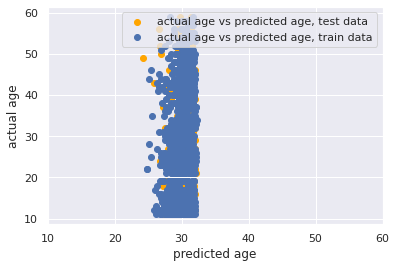

Mean Absolute Error: 10.563163094254522
Mean Squared Error: 157.49685126077802
Root Mean Squared Error: 12.549774948610752


In [ ]:
plt.scatter(y_pred[:,1],y_test[:,1],color='orange',label='actual age vs predicted age, test data')
plt.scatter(y_pred_train[:,1],y_train[:,1], label ='actual age vs predicted age, train data')
plt.xlabel('predicted age')
plt.ylabel('actual age')
plt.xlim(10,60)
plt.legend()
plt.savefig('tensor_prediction_utso_age_1.pdf')
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test[:,1], y_pred[:,1]))
print('Mean Squared Error:', metrics.mean_squared_error(y_test[:,1], y_pred[:,1]))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test[:,1],y_pred[:,1])))


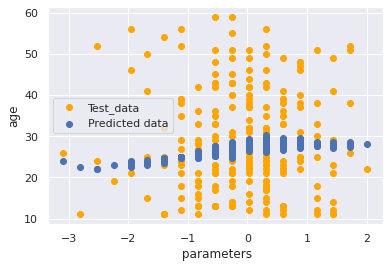

In [ ]:
#X_test_original=sc.inverse_transform(X_test)
plt.scatter(X_test[:,1],y_test[:,1],color='orange',label='Test_data')
plt.scatter(X_test[:,1],y_pred[:,1], label='Predicted data')
plt.xlabel(' parameters')
plt.ylabel('age')
plt.legend()
plt.savefig('tensor_prediction_velocity_age_2.pdf')

#### I2MC

In [ ]:
X = np.vstack((fixation_duration_i2mc,nr_fixation_i2mc)).T
y = np.vstack((gender_i2mc, age_i2mc)).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

n_features = X_train.shape[1]
print(n_features)

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)
output = Dense(2)(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit(X_train, y_train, batch_size=5, epochs=100, verbose=2, validation_split=0.1)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)


2
Epoch 1/100
159/159 - 1s - loss: 279.9500 - mean_squared_error: 279.9500 - val_loss: 98.9338 - val_mean_squared_error: 98.9338
Epoch 2/100
159/159 - 0s - loss: 106.3733 - mean_squared_error: 106.3733 - val_loss: 84.3185 - val_mean_squared_error: 84.3185
Epoch 3/100
159/159 - 0s - loss: 97.9177 - mean_squared_error: 97.9177 - val_loss: 85.6625 - val_mean_squared_error: 85.6625
Epoch 4/100
159/159 - 0s - loss: 92.0005 - mean_squared_error: 92.0005 - val_loss: 84.1519 - val_mean_squared_error: 84.1519
Epoch 5/100
159/159 - 0s - loss: 90.2305 - mean_squared_error: 90.2305 - val_loss: 85.4777 - val_mean_squared_error: 85.4777
Epoch 6/100
159/159 - 0s - loss: 86.1825 - mean_squared_error: 86.1825 - val_loss: 86.0799 - val_mean_squared_error: 86.0799
Epoch 7/100
159/159 - 0s - loss: 86.6913 - mean_squared_error: 86.6913 - val_loss: 84.7427 - val_mean_squared_error: 84.7427
Epoch 8/100
159/159 - 0s - loss: 84.1336 - mean_squared_error: 84.1336 - val_loss: 87.0868 - val_mean_squared_error: 87

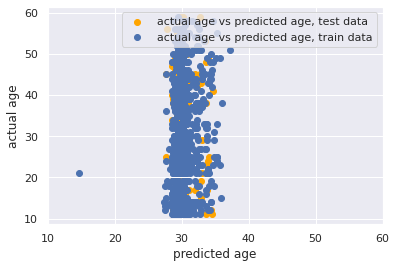

Mean Absolute Error: 10.675297689653629
Mean Squared Error: 161.0651970369193
Root Mean Squared Error: 12.69114640357282


In [ ]:
plt.scatter(y_pred[:,1],y_test[:,1],color='orange',label='actual age vs predicted age, test data')
plt.scatter(y_pred_train[:,1],y_train[:,1], label ='actual age vs predicted age, train data')
plt.xlabel('predicted age')
plt.ylabel('actual age')
plt.xlim(10,60)
plt.legend()
plt.savefig('tensor_prediction_i2mc_age_1.pdf')
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test[:,1], y_pred[:,1]))
print('Mean Squared Error:', metrics.mean_squared_error(y_test[:,1], y_pred[:,1]))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test[:,1],y_pred[:,1])))

###Using Velocity as the input

In [ ]:
nr_freq = 10
velocity_fft_final =np.zeros((1163,nr_freq))
freq_fft = np.zeros((1163,nr_freq))

for k in range (1163):
    velocity1 = full_data[k][3][:]
    velocity1_fft=abs(np.fft.fft(velocity1))[1:]
    velocity1_fft_sum = 0
    for l in range (round((np.shape(velocity1_fft)[0])/2)):
        velocity1_fft_sum+=velocity1_fft[l]
    normalized_velocity1_fft = velocity1_fft[0:round(np.shape(velocity1_fft)[0]/2)]/velocity1_fft_sum
    velocity1_fft_final = np.sort (normalized_velocity1_fft)[::-1]
    position_freq1_final = np.argsort (normalized_velocity1_fft)[::-1]
    freq_velocity1_fft = 0.5*60/np.shape(normalized_velocity1_fft) [0] * position_freq1_final
    if full_data[k][10][1] == 'FEMALE' or full_data[k][10][1] == 'MALE':
        velocity_fft_final [k] = velocity1_fft_final [0:nr_freq]
        freq_fft [k] = freq_velocity1_fft [0:nr_freq]

20
Epoch 1/100
168/168 - 1s - loss: 205.8322 - mean_squared_error: 205.8322 - val_loss: 114.6399 - val_mean_squared_error: 114.6399
Epoch 2/100
168/168 - 0s - loss: 94.9979 - mean_squared_error: 94.9979 - val_loss: 105.7140 - val_mean_squared_error: 105.7140
Epoch 3/100
168/168 - 0s - loss: 88.3786 - mean_squared_error: 88.3786 - val_loss: 96.9914 - val_mean_squared_error: 96.9913
Epoch 4/100
168/168 - 0s - loss: 85.0428 - mean_squared_error: 85.0428 - val_loss: 96.0873 - val_mean_squared_error: 96.0873
Epoch 5/100
168/168 - 0s - loss: 81.1040 - mean_squared_error: 81.1040 - val_loss: 94.9199 - val_mean_squared_error: 94.9199
Epoch 6/100
168/168 - 0s - loss: 79.9609 - mean_squared_error: 79.9609 - val_loss: 95.1378 - val_mean_squared_error: 95.1378
Epoch 7/100
168/168 - 0s - loss: 77.8101 - mean_squared_error: 77.8101 - val_loss: 94.8409 - val_mean_squared_error: 94.8409
Epoch 8/100
168/168 - 0s - loss: 78.9489 - mean_squared_error: 78.9489 - val_loss: 94.1811 - val_mean_squared_error:

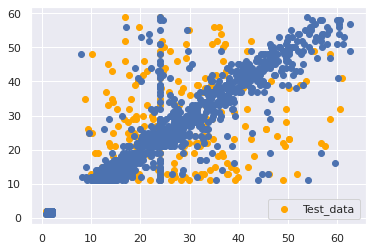

In [ ]:
X = np.concatenate((velocity_fft_final,freq_fft), axis =1)  
y = np.vstack((gender, age)).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

n_features = X_train.shape[1]
print(n_features)

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)
output = Dense(2)(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit(X_train, y_train, batch_size=5, epochs=100, verbose=2, validation_split=0.1)

y_pred_train = model.predict(X_train)
#print(np.shape(pred_train))
#print(np.shape(y_train))
print(np.sqrt(mean_squared_error(y_train[:,1],y_pred_train[:,1])))

y_pred = model.predict(X_test)
#print(np.shape(pred))
print(np.sqrt(mean_squared_error(y_test[:,1],y_pred[:,1])))

plt.scatter(y_pred,y_test,color='orange',label='Test_data')
plt.scatter(y_pred_train,y_train)
plt.legend()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test[:,1], y_pred[:,1]))
print('Mean Squared Error:', metrics.mean_squared_error(y_test[:,1], y_pred[:,1]))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test[:,1], y_pred[:,1])))


In [ ]:
print(np.shape(X_test))
print(np.shape(y_test[:,1]))

(233, 20)
(233,)


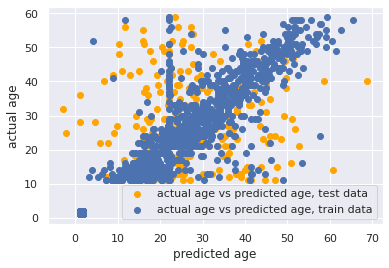

Mean Absolute Error: 13.863366110642069
Mean Squared Error: 307.5717071616266


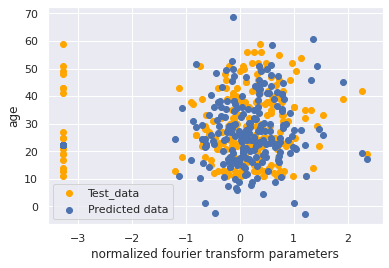

In [ ]:
import matplotlib.pyplot as plt2
os. chdir('/content')
plt2.scatter(y_pred,y_test,color='orange',label='actual age vs predicted age, test data')
plt2.scatter(y_pred_train,y_train, label ='actual age vs predicted age, train data')
plt2.xlabel('predicted age')
plt2.ylabel('actual age')
plt2.legend()
plt2.savefig('tensor_prediction_velocity_age_1.pdf')
plt2.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test[:,1], y_pred[:,1]))
print('Mean Squared Error:', metrics.mean_squared_error(y_test[:,1], y_pred[:,1]))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test[:,1], y_pred[:,1]))
plt2.scatter(X_test [:,1] ,y_test [:,1],color='orange', label='Test_data')
plt2.scatter(X_test[:,1],y_pred[:,1], label='Predicted data')
plt2.xlabel('normalized fourier transform parameters')
plt2.ylabel('age')
plt2.legend()
plt2.savefig('tensor_prediction_velocity_age_2.pdf')

0.5196741559574052
0.5366072927055848
Mean Absolute Error gender: 0.5090892146073698
Mean Squared Error gender: 0.28794738658481717
Root Mean Squared Error gender: 0.5366072927055848


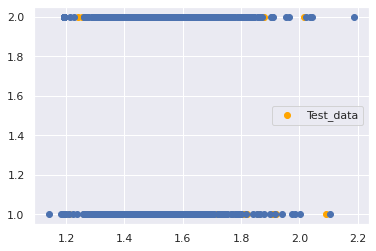

In [ ]:
y_pred_train = model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train[:,0],y_pred_train[:,0])))

y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test[:,0],y_pred[:,0])))
os. chdir('/content')
plt.scatter(y_pred[:,0],y_test[:,0],color='orange',label='Test_data')
plt.scatter(y_pred_train[:,0],y_train[:,0])
plt.legend()
plt.savefig('prediction_velocity_gender.pdf')
print('Mean Absolute Error gender:', metrics.mean_absolute_error(y_test[:,0], y_pred[:,0]))
print('Mean Squared Error gender:', metrics.mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Root Mean Squared Error gender:', np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred[:,0])))